# Projet Fil Rouge 2022 : Reconnaissance de commandes audio


**Noms :**  Bouchikhi, Couallier

**Prénoms :** Yousra, Joanne

**Nom du binôme :** Yousra & Joanne




Ces six séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="files/DroneJS.JPG" width="600" height="500"  >



Ces séances se décomposent en 4 parties : 
- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude




In [232]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns
import time
import pandas as pd
import librosa
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

# Preprocessing


Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appelés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel de signal audio.

La matrice de sortie est composée d'autant de vecteurs colonnes que de trames d'analyses. Le nombre de lignes correspond au nombre de coefficients MFCC choisis : ici 12.


## Transformation des données 

In [233]:
Nb_SegmentMFCC=2       # domaine fréquentiel
Nb_SegmentSignal=1000  # véritable signal
Nb_coeffMFCC=12        # nombre de coefficients de mfcc 

# Fonction permettant de discrétiser le signal ou les mfcc, noté y, en Nb_segment 
# sur chaque fenêtre on extrait la moyenne

def ReductionMemeDimension(y,Nb_Segment):
    n_mfcc,n_info=np.shape(y)
    Nouvelle_donnees=np.zeros((n_mfcc,Nb_Segment))
    Nb_FenetreParSegment=math.floor(n_info/(Nb_Segment))

    for j in range(n_mfcc):
        for i in range(0,Nb_Segment):
            Nouvelle_donnees[j,i]=np.mean(y[j,i*Nb_FenetreParSegment:(i+1)*Nb_FenetreParSegment])

    return Nouvelle_donnees

Nouvelle_donnees est une matrice de taille $nb_{mfcc} * Nb_{segment}$

### Construction de la base de données d'étude avec 12 coefficients MFCC

In [234]:
path = "toutlesdonnees"  #chemin vers les données utilisées dans cette partie d'étude
fichiers = [f for f in listdir("./" +path)] #résupérer les fichiers audios
nb_fichier=len(fichiers)

#taille moyenne des fichiers
moy = 0
for i in range(len(fichiers)):
    y, sr = librosa.load(path+"/" + fichiers[i])
    moy += librosa.get_duration(y,sr)

duration_moy = moy / len(fichiers)
# La base complète : 
Base=[]
for i in range(len(fichiers)):
    y, sr = librosa.load(path+"/" + fichiers[i])
    #suppression des blancs
    yt, index = librosa.effects.trim(y,top_db=60)
    #durée de l'audio
    duration = librosa.get_duration(yt,sr)
    #mettre les audios à la même longueur
    yt = librosa.effects.time_stretch(yt, rate= duration/duration_moy)
    mfccBA = librosa.feature.mfcc(y=yt, sr=sr, hop_length=1024, htk=True, n_mfcc=12)
    mfccBAReduc=np.ravel(ReductionMemeDimension(mfccBA,Nb_SegmentMFCC))
    # print(mfccBAReduc.shape)
    Base.append(mfccBAReduc)

Base = np.asarray(Base)
Base.shape

(800, 24)

### Construction de la base de données d'étude avec 10 puis 15 coefficients MFCC

In [235]:
# La base en gardant 10 mfcc  : 
Base10=[]
for i in range(len(fichiers)):
    y, sr = librosa.load(path+"/" + fichiers[i])
    #suppression des blancs
    yt, index = librosa.effects.trim(y,top_db=60)
    #durée de l'audio
    duration = librosa.get_duration(yt,sr)
    #mettre les audios à la même longueur
    yt = librosa.effects.time_stretch(yt, rate= duration/duration_moy)
    mfccBA = librosa.feature.mfcc(y=yt, sr=sr, hop_length=1024, htk=True, n_mfcc=10)
    mfccBAReduc=np.ravel(ReductionMemeDimension(mfccBA,Nb_SegmentMFCC))
    # print(mfccBAReduc.shape)
    Base10.append(mfccBAReduc)

Base10 = np.asarray(Base10)

# La base en gardant 15 mfcc  : 
Base15=[]
for i in range(len(fichiers)):
    y, sr = librosa.load(path+"/" + fichiers[i])
    #suppression des blancs
    yt, index = librosa.effects.trim(y,top_db=60)
    #durée de l'audio
    duration = librosa.get_duration(yt,sr)
    #mettre les audios à la même longueur
    yt = librosa.effects.time_stretch(yt, rate= duration/duration_moy)
    mfccBA = librosa.feature.mfcc(y=yt, sr=sr, hop_length=1024, htk=True, n_mfcc=15)
    mfccBAReduc=np.ravel(ReductionMemeDimension(mfccBA,Nb_SegmentMFCC))
    # print(mfccBAReduc.shape)
    Base15.append(mfccBAReduc)

Base15 = np.asarray(Base15)

## Label des enregistrements : étiquettage des données via le nom du fichier .wav

In [236]:
#pip install fuzzywuzzy   #à décommenter si la librairie n'est pas déjà téléchargée

In [237]:
import re
from fuzzywuzzy import process

if path == "dronevolant_nonbruite" :
    ListeOrdre=['tournedroite', 'tournegauche','avance', 'recule', 'gauche', 'droite', 'arretetoi', \
    'atterissage', 'decollage', 'etatdurgence', \
    'faisunflip', 'plusbas', 'plushaut']
else : 
    ListeOrdre=['tournedroite', 'tournegauche','avance', 'recule', 'gauche', 'droite', 'arretetoi', \
    'atterissage', 'decollage', 'etatdurgence', \
    'faisunflip', 'plusbas', 'plushaut', 'penduleinverse']

# fonction pour affecter une classe à chaque fichier audio 
def EtiquetterFichier(Fichier,ListeOrdre):
    NbFichier=len(Fichier)
    NumClasse = dict(zip(ListeOrdre, range(len(ListeOrdre))))
    print(NumClasse)
    Classe=np.zeros((NbFichier,1))
    for NumF in range(NbFichier):
        #for num in range(NbOrdre):
        fileAudio=Fichier[NumF]
        result = process.extract(fileAudio,ListeOrdre)[0][0]
        if result:
            Classe[NumF]= NumClasse[result]
    return Classe, NumClasse

#étiquetage des données
NbOrdre=len(ListeOrdre)
Label, dict_Label=EtiquetterFichier(fichiers,ListeOrdre)
dict_classe = dict(zip(range(len(ListeOrdre)), ListeOrdre))
Label=np.ravel(Label)

{'tournedroite': 0, 'tournegauche': 1, 'avance': 2, 'recule': 3, 'gauche': 4, 'droite': 5, 'arretetoi': 6, 'atterissage': 7, 'decollage': 8, 'etatdurgence': 9, 'faisunflip': 10, 'plusbas': 11, 'plushaut': 12, 'penduleinverse': 13}


14


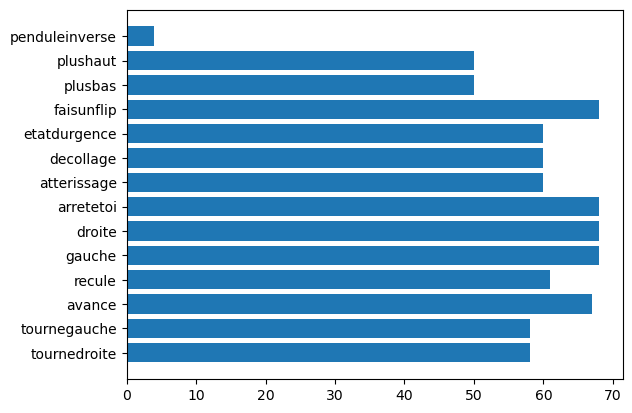

In [238]:
nb = pd.DataFrame(Label).value_counts(sort=False)
plt.barh(ListeOrdre, nb)
print(len(np.unique(Label)))

### Justification du choix du nombre de coefficients MFCC :

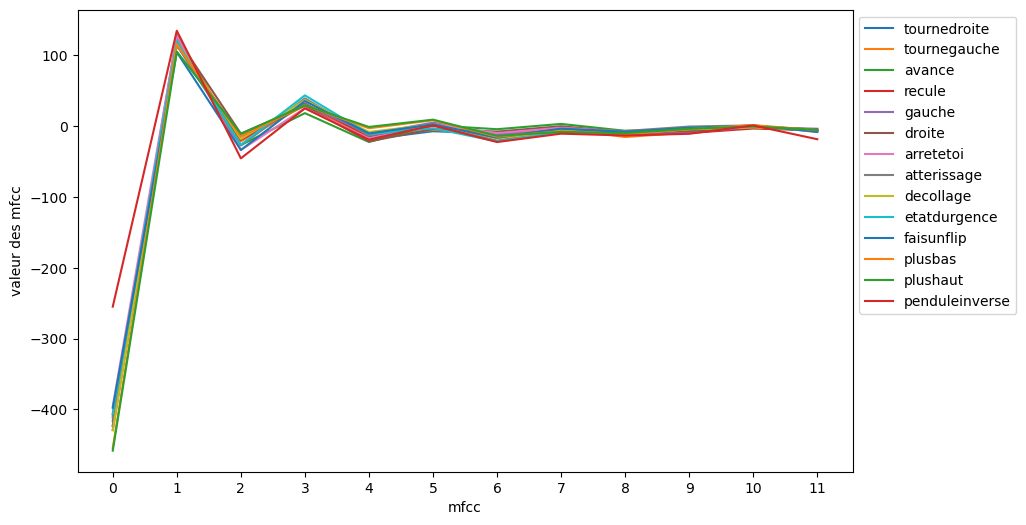

In [239]:
size_legend = 12
Basegraphe = pd.DataFrame()
Basegraphe['0'] = np.mean(Base[:,0:1], axis = 1)
Basegraphe['1'] = np.mean(Base[:,2:3], axis = 1)
Basegraphe['2'] = np.mean(Base[:,4:5], axis = 1)
Basegraphe['3'] = np.mean(Base[:,6:7], axis = 1)
Basegraphe['4'] = np.mean(Base[:,8:9], axis = 1)
Basegraphe['5'] = np.mean(Base[:,10:11], axis = 1)
Basegraphe['6'] = np.mean(Base[:,12:13], axis = 1)
Basegraphe['7'] = np.mean(Base[:,14:15], axis = 1)
Basegraphe['8'] = np.mean(Base[:,16:17], axis = 1)
Basegraphe['9'] = np.mean(Base[:,18:19], axis = 1)
Basegraphe['10'] = np.mean(Base[:,20:21], axis = 1)
Basegraphe['11'] = np.mean(Base[:,22:23], axis = 1)

Basegraphe['Label'] = Label
Basegraphe12 = Basegraphe.groupby('Label').mean()

plt.figure(figsize=(10,6))
plt.plot(np.transpose(Basegraphe12), )
plt.xlabel("mfcc")
plt.ylabel("valeur des mfcc")
plt.legend(ListeOrdre, bbox_to_anchor =(1, 1), ncol = 1)
plt.show()

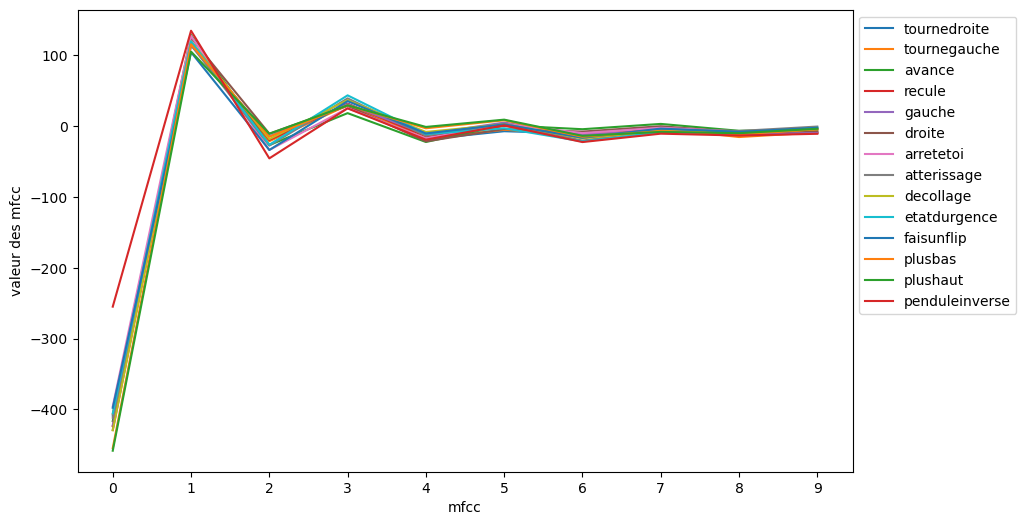

In [240]:
size_legend = 10
Basegraphe10 = pd.DataFrame()
Basegraphe10['0'] = np.mean(Base10[:,0:1], axis = 1)
Basegraphe10['1'] = np.mean(Base10[:,2:3], axis = 1)
Basegraphe10['2'] = np.mean(Base10[:,4:5], axis = 1)
Basegraphe10['3'] = np.mean(Base10[:,6:7], axis = 1)
Basegraphe10['4'] = np.mean(Base10[:,8:9], axis = 1)
Basegraphe10['5'] = np.mean(Base10[:,10:11], axis = 1)
Basegraphe10['6'] = np.mean(Base10[:,12:13], axis = 1)
Basegraphe10['7'] = np.mean(Base10[:,14:15], axis = 1)
Basegraphe10['8'] = np.mean(Base10[:,16:17], axis = 1)
Basegraphe10['9'] = np.mean(Base10[:,18:19], axis = 1)

Basegraphe10['Label'] = Label
Basegraphe10 = Basegraphe10.groupby('Label').mean()

plt.figure(figsize=(10,6))
plt.plot(np.transpose(Basegraphe10), )
plt.xlabel("mfcc")
plt.ylabel("valeur des mfcc")
plt.legend(ListeOrdre, bbox_to_anchor =(1, 1), ncol = 1)
plt.show()

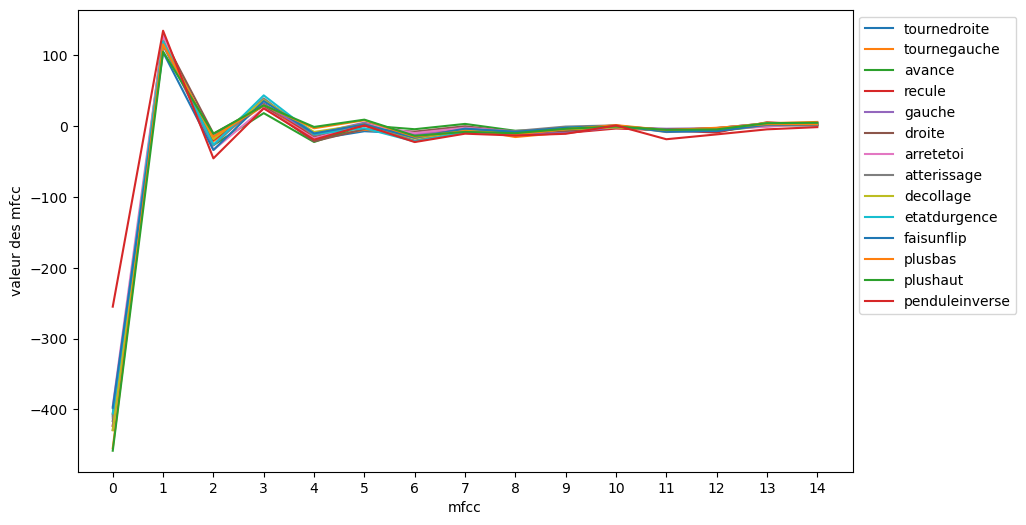

In [241]:
size_legend = 15
Basegraphe15 = pd.DataFrame()
Basegraphe15['0'] = np.mean(Base15[:,0:1], axis = 1)
Basegraphe15['1'] = np.mean(Base15[:,2:3], axis = 1)
Basegraphe15['2'] = np.mean(Base15[:,4:5], axis = 1)
Basegraphe15['3'] = np.mean(Base15[:,6:7], axis = 1)
Basegraphe15['4'] = np.mean(Base15[:,8:9], axis = 1)
Basegraphe15['5'] = np.mean(Base15[:,10:11], axis = 1)
Basegraphe15['6'] = np.mean(Base15[:,12:13], axis = 1)
Basegraphe15['7'] = np.mean(Base15[:,14:15], axis = 1)
Basegraphe15['8'] = np.mean(Base15[:,16:17], axis = 1)
Basegraphe15['9'] = np.mean(Base15[:,18:19], axis = 1)
Basegraphe15['10'] = np.mean(Base15[:,20:21], axis = 1)
Basegraphe15['11'] = np.mean(Base15[:,22:23], axis = 1)
Basegraphe15['12'] = np.mean(Base15[:,23:24], axis = 1)
Basegraphe15['13'] = np.mean(Base15[:,24:25], axis = 1)
Basegraphe15['14'] = np.mean(Base15[:,25:26], axis = 1)


Basegraphe15['Label'] = Label
Basegraphe15 = Basegraphe15.groupby('Label').mean()

plt.figure(figsize=(10,6))
plt.plot(np.transpose(Basegraphe15), )
plt.xlabel("mfcc")
plt.ylabel("valeur des mfcc")
plt.legend(ListeOrdre, bbox_to_anchor =(1, 1), ncol = 1)
plt.show()

On remarque que pour 10 mfcc ou 15 mfcc, il y a très peu de variation entre les coefficients. Apprendre sur des données avec plus de mfcc ne serait donc pas utile. On va donc bien garder 12 coefficients mfcc.

### Choix des labels

Ici il y a beaucoup de labels différents (13) par rapport au nombre de données disponible. On souhaite donc choisir 3 labels sur lesquels entraîner nos modèles. Pour cela on va faire en sorte de choisir des labels pour lesquels les données sont bien différentes. 

En effet, si plusieurs enregistrements ont des valeurs de mfcc proches mais des labels différents, le modèle ne pourra pas apprendre correctement.

On cherche donc à trouver les labels tels que les valeurs des mfcc sont les plus différentes possibles.

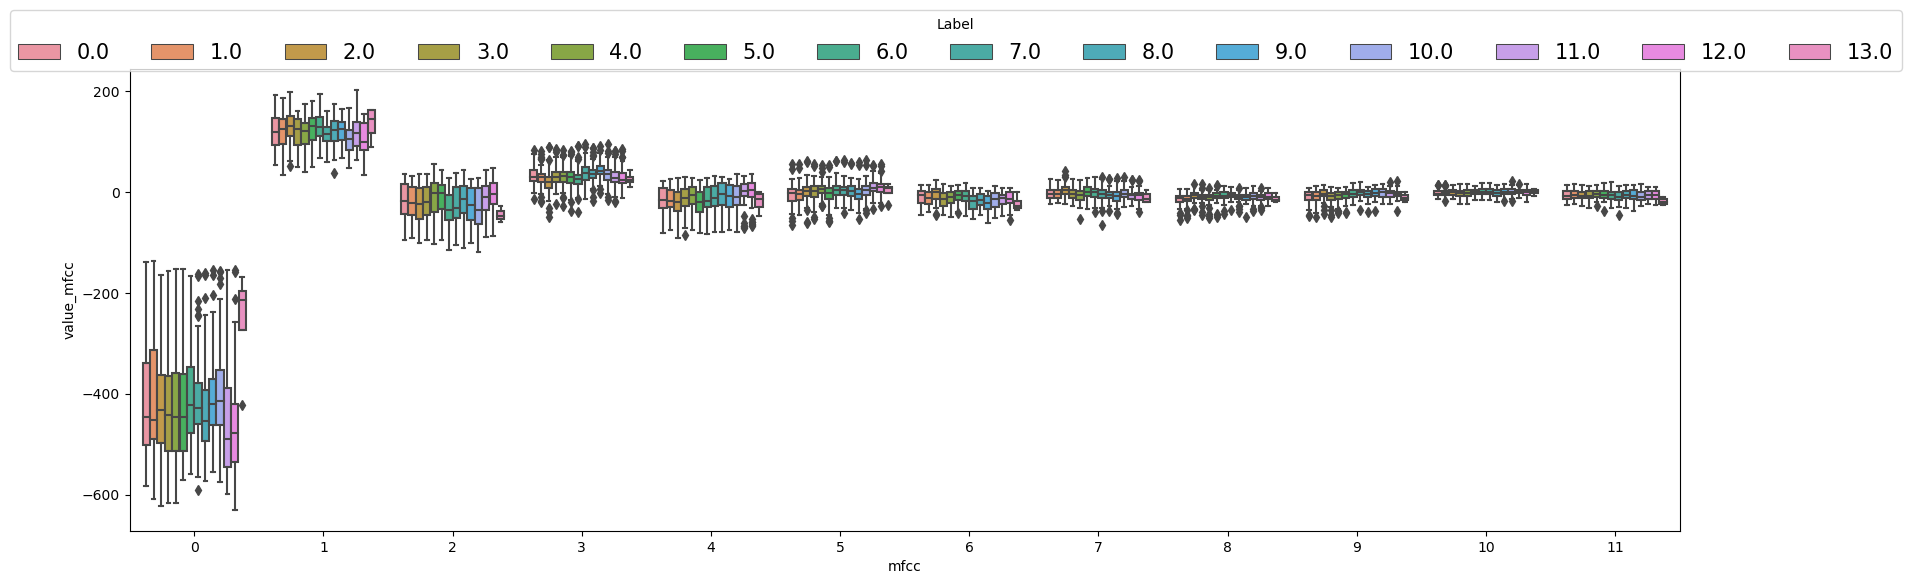

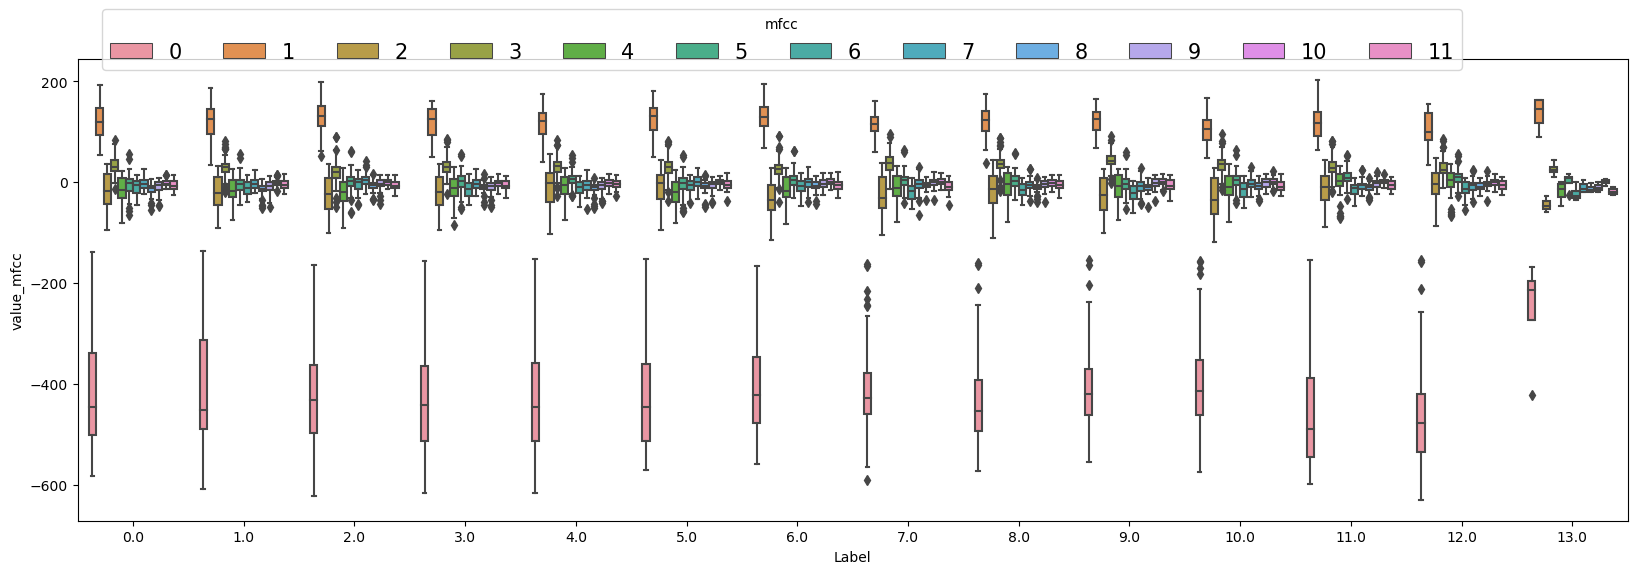

In [242]:
Basegraphe_melt = pd.melt(Basegraphe, id_vars='Label',  var_name='mfcc', value_name='value_mfcc', col_level=None, ignore_index=True)

plt.figure(figsize=(20,6))
sns.boxplot(x = Basegraphe_melt['mfcc'],
            y = Basegraphe_melt['value_mfcc'],
            hue = Basegraphe_melt['Label'])
plt.legend(title = "Label",bbox_to_anchor =(1.15, 1.15), ncol = 14, fontsize = size_legend)
plt.savefig('mfccBoxplot.png')
plt.show()

plt.figure(figsize=(20,6))
sns.boxplot(x = Basegraphe_melt['Label'],
            y = Basegraphe_melt['value_mfcc'],
            hue = Basegraphe_melt['mfcc'])
plt.legend(title = "mfcc",bbox_to_anchor =(0.9, 1.13), ncol = 12, fontsize = size_legend)
plt.show()

Sur le graphe, il est difficile de distinguer les écarts entre les boxplots . De la même manière que sur le graphe précédent des valeurs moyennes par label.

On distingue le label 13 ("pendule inverse") qui est très différent des autres, mais nous ne disposons que de très peu d'enregistrements pour ce label, on l'enlève donc de l'étude.

Pour mieux distinguer l'écart entre les labels, nous allons donc calculer la distance moyenne entre chaque courbe des valeurs moyennes de mfcc.

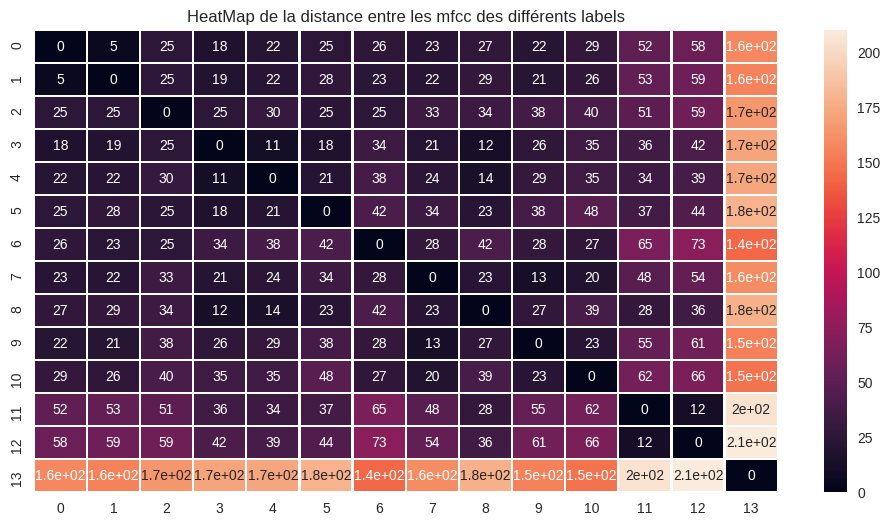

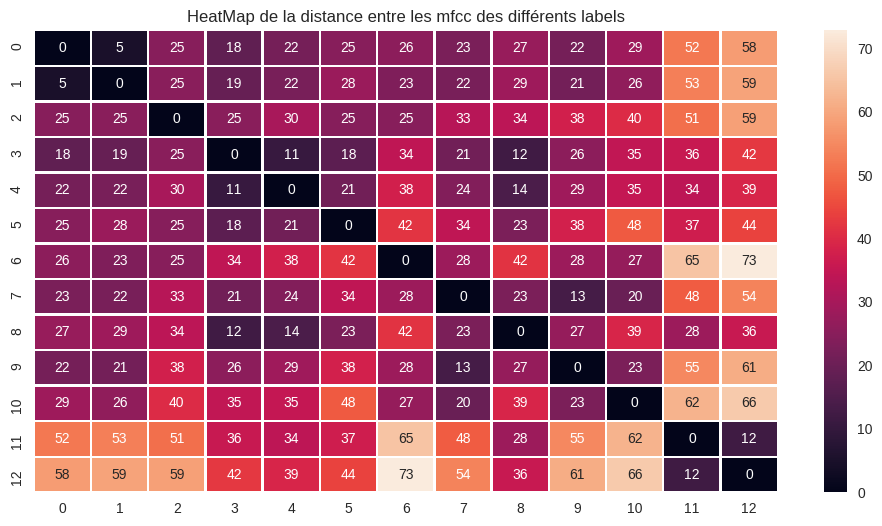

In [243]:
dist = np.zeros((Basegraphe12.shape[0], Basegraphe.shape[0]))
for i in range(Basegraphe12.shape[0]) :
    for j in range(Basegraphe12.shape[0]) :
        dist[i,j] = np.linalg.norm(Basegraphe12.iloc[i,:] - Basegraphe12.iloc[j,:])

import seaborn as sns
import matplotlib.pylab as plt
plt.style.use("seaborn")

plt.figure(figsize=(12,6))
heat_map = sns.heatmap(dist[0:14, 0:14], linewidth = 1 , annot = True)
plt.title( "HeatMap de la distance entre les mfcc des différents labels" )
plt.show()

plt.figure(figsize=(12,6))
heat_map = sns.heatmap(dist[0:13, 0:13], linewidth = 1 , annot = True)
plt.title( "HeatMap de la distance entre les mfcc des différents labels" )
plt.savefig('heatmap_mfcc.png')
plt.show()

In [244]:
print(dict_classe)

{0: 'tournedroite', 1: 'tournegauche', 2: 'avance', 3: 'recule', 4: 'gauche', 5: 'droite', 6: 'arretetoi', 7: 'atterissage', 8: 'decollage', 9: 'etatdurgence', 10: 'faisunflip', 11: 'plusbas', 12: 'plushaut', 13: 'penduleinverse'}



* on affiche la matrice sans le label 13 ("pendule inverse") pour avoir une échelle de couleurs plus adaptée. L'objectif est de choisir des labels tels que la distance aux autres labels choisis est grande. 

* on peut d'abord choisir un label parmis 11 et 12 qui sont très proches entre eux, mais très éloignés de tous les autres
* on choisit ensuite les labels 5, 6 qui sont relativement éloignés l'un de l'autre.

On propose donc de garder : `droite`, `arretetoi`, `plushaut`.

3


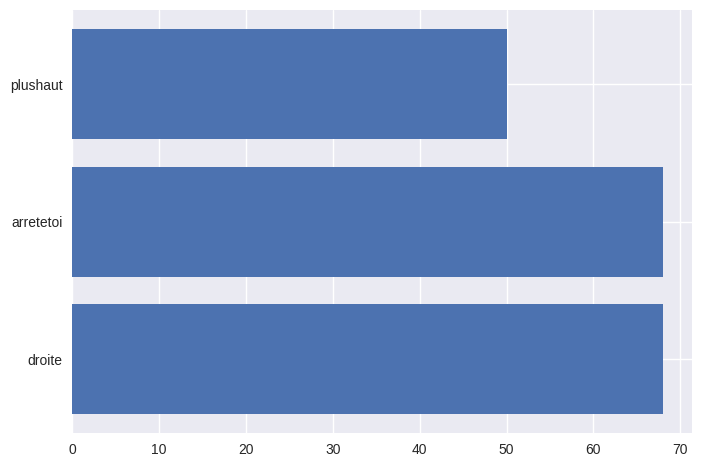

In [245]:
keep_label = ['droite', 'arretetoi', 'plushaut']

def reduction_Label(Base, Label, keep_label, dict_Label) :
    #récupérer les indices correspondant aux labels retenus
    ind = []
    for chaine in keep_label : 
        ind = ind + list(np.where(Label == dict_Label[chaine])[0])
    ind = np.asarray(ind)
    Label_new = Label[ind]
    #renuméroter les labels gardés 
    for i in range(len(keep_label)) : 
        Label_new[Label_new == dict_Label[keep_label[i]]] = i
    return Base[ind], Label_new

Base3 , Label3 = reduction_Label(Base, Label, keep_label, dict_Label)
dict_classe3 = dict(zip(range(len(keep_label)), keep_label))

nb = pd.DataFrame(Label3).value_counts()
plt.barh(keep_label, nb)
print(len(np.unique(Label3)))


## Construction de la base d'apprentissage et de test sans répétition des éléments 

Pour la construction de nos bases de données d'apprentissage et de test, on choisit de garder 80% des données pour l'apprentissage et 20% pour le test, sans remise.

On fait aussi en sorte de garder les mêmes proportions de chaque label. C'est à dire, que pour chaque label, on tire aléatoirement 80% des données pour l'apprentissage et 20% pour le test, et on continue sur les labels suivants.

In [246]:
np.random.seed(2020)
def get_App_Test(Base, Label) :

    BaseApp = []
    LabelApp = []
    BaseTest = []
    LabelTest = []
    nbvalApp = 0
    nbvalTest = 0

    for i in np.unique(Label) :
        l = np.where(Label == i)[0]
        n = len(l)
        indTest = np.random.choice(l, int(n*0.2))
        nbvalTest += len(indTest)
        indApp = np.array(list(set(l).difference(set(indTest))))
        nbvalApp += len(indApp)
        BaseApp.append(Base[indApp])
        LabelApp.append(Label[indApp])
        BaseTest.append(Base[indTest])
        LabelTest.append(Label[indTest])

    BaseApp = np.reshape(np.vstack(BaseApp), (nbvalApp,Nb_SegmentMFCC*Nb_coeffMFCC))
    BaseTest = np.reshape(np.vstack(BaseTest), (nbvalTest, Nb_SegmentMFCC*Nb_coeffMFCC))
    LabelApp = np.concatenate(LabelApp, axis=0)
    LabelTest = np.concatenate(LabelTest, axis=0)
    return BaseApp, BaseTest, LabelApp, LabelTest

BaseApp, BaseTest, LabelApp, LabelTest = get_App_Test(Base3, Label3)
print("Taille de la base de test:", BaseTest.shape)
print("Taille de la base d'apprentissage:",BaseApp.shape)

Taille de la base de test: (36, 24)
Taille de la base d'apprentissage: (152, 24)


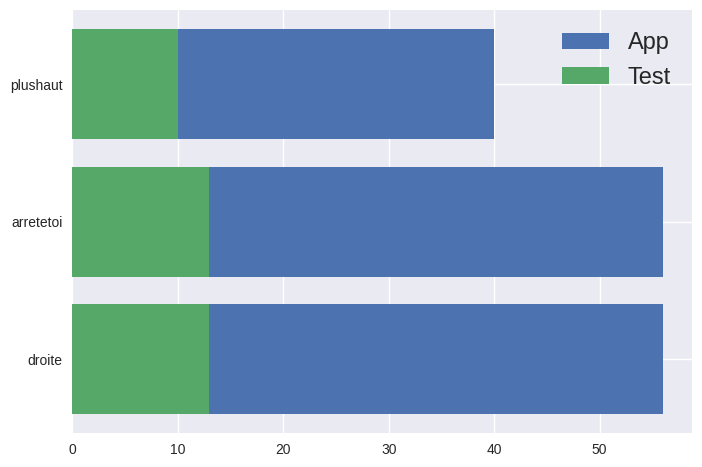

In [247]:
nb = pd.DataFrame(LabelApp).value_counts()
plt.barh(keep_label, nb)
nb = pd.DataFrame(LabelTest).value_counts()
plt.barh(keep_label, nb)
plt.legend(["App" ,"Test"], fontsize = size_legend+2)
plt.savefig('AppTest.png')
plt.show()

In [248]:
import matplotlib
plt.rcParams.update(matplotlib.rcParamsDefault)

### Normalisation des données 

In [249]:
# rescaling 
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
BaseApp_scale = scale.fit_transform(BaseApp)
BaseTest_scale = scale.fit_transform(BaseTest)

from sklearn.preprocessing import MinMaxScaler
BaseApp_minmax = MinMaxScaler(feature_range=(0, 1)).fit(BaseApp).transform(BaseApp)
BaseTest_minmax = MinMaxScaler(feature_range=(0, 1)).fit(BaseTest).transform(BaseTest)

### Données réduites avec l'ACP : 

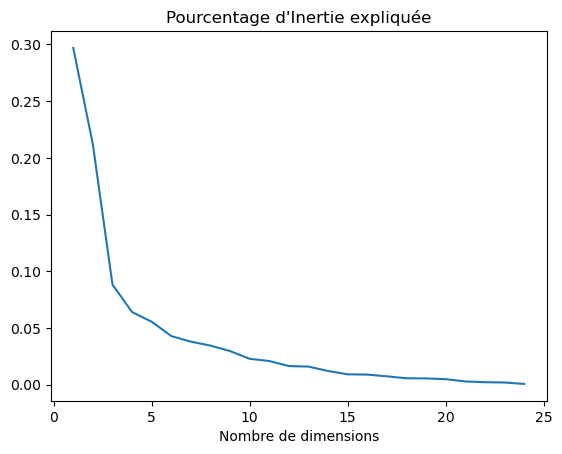

In [250]:
from sklearn.decomposition import PCA

pca = PCA()
plt.plot(range(1,len(pca.fit(BaseApp_scale).explained_variance_ratio_)+1),pca.fit(BaseApp_scale).explained_variance_ratio_)
plt.title("Pourcentage d'Inertie expliquée")
plt.xlabel("Nombre de dimensions")
plt.show()

On va donc garder 3 dimensions.

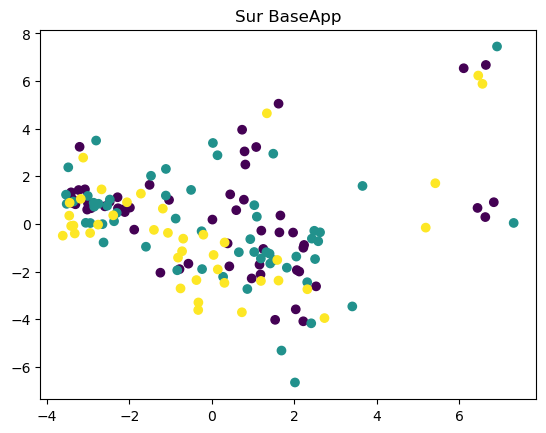

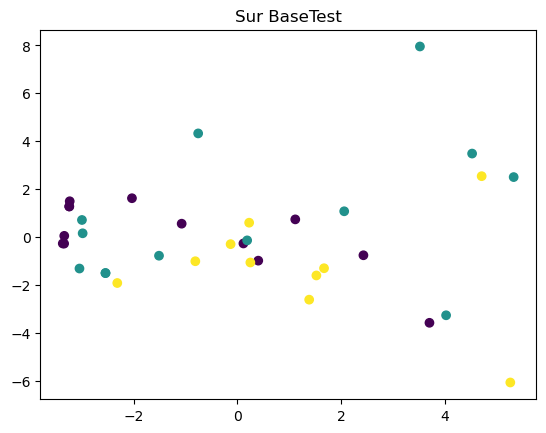

In [251]:
pca = PCA(n_components=3)
BaseApp_pca = pca.fit_transform(BaseApp_scale)
plt.scatter(BaseApp_pca[:,0], BaseApp_pca[:,1], c = LabelApp)
plt.title("Sur BaseApp")
plt.show()

pca = PCA(n_components=3)
BaseTest_pca = pca.fit_transform(BaseTest_scale)
plt.scatter(BaseTest_pca[:,0], BaseTest_pca[:,1], c = LabelTest)
plt.title("Sur BaseTest")
plt.show()

# Partie I : Sélection de modèles et pénalisation

### 1. Régression Multiclasse

Appliquer un modèle de **régression multiclasses**.

On modélise les probabilités par la forme suivante :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } { 1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
Pour tout $j$ dans $\{ 1,2, \dots , K-1 \}$.

On peut aussi considérer un modèle binomiale par classe pour l'analyse. i.e (Considérer les labels dans la classe $k$ comme étant 1 et les autres labels 0)

In [252]:
# Modèle de régression 
from sklearn.linear_model import LogisticRegression

# LogisticRegression : 
# penalty : 'none', 'l2', 'l1', 'elasticnet'
# C : inverse of regularization strength : entre 0 et 1 (petit = stronger regularization)
# solver : 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'

import itertools
opt_list = ['lbfgs', 'saga', 'sag', 'newton-cg']
experiences = {'opti':opt_list, 'C': [0.1, 0.5, 1, 2, 5, 10, 15]} #'penalty':['l1', 'l2', 'elasticnet', 'none']}
dfexp = pd.DataFrame(list(itertools.product(*experiences.values())), columns=experiences.keys())

# calcul du score pour chaque expérience :
def exp_Logist(row, App, Test, multiclasse="multinomial"):
    df = row.copy()
    # 1st column = score app
    # 2nd column = score test
    # 3rd column = time of execution
    result = np.zeros((np.shape(df)[0],3))
    penalty = 'none'
    for i in range(np.shape(row)[0]):
        if multiclasse == "multinomial" :
            t1 = time.time()
            model = LogisticRegression(solver = df.opti[i], C=df.C[i] ,fit_intercept = False, multi_class='multinomial', random_state=0).fit(App, LabelApp)
            t2 = time.time()
        elif multiclasse == "ovr" :
            t1 = time.time()
            model = LogisticRegression(solver = df.opti[i], C=df.C[i] ,fit_intercept = False, multi_class='ovr', random_state=0).fit(App, LabelApp)
            t2 = time.time()
        result[i,0] = model.score(App, LabelApp)
        result[i,1] = model.score(Test, LabelTest)
        result[i,2] = t2-t1
    
    df[['score_app']] = pd.DataFrame(result[:,0])
    df[['score_test']] = pd.DataFrame(result[:,1])
    df[['time_ex']] = pd.DataFrame(result[:,2])
    return df

In [253]:
result_brute = exp_Logist(dfexp, BaseApp, BaseTest)
result_brute_sorted = result_brute.sort_values(by = ['score_test','score_app','time_ex'], ascending = [False,False,True])
result_brute_sorted

,opti,C,score_app,score_test,time_ex
21,newton-cg,0.1,0.934211,0.888889,0.020121
2,lbfgs,1.0,0.921053,0.888889,0.014259
3,lbfgs,2.0,0.907895,0.888889,0.015814
4,lbfgs,5.0,0.907895,0.861111,0.014283
1,lbfgs,0.5,0.907895,0.861111,0.014898
20,sag,15.0,0.868421,0.861111,0.005268
16,sag,1.0,0.868421,0.861111,0.005276
17,sag,2.0,0.868421,0.861111,0.005295
18,sag,5.0,0.868421,0.861111,0.005301
15,sag,0.5,0.868421,0.861111,0.005329


#### Implémentation d'une fonction générique qui choisit les paramètres les plus adaptés à un modèle dans le cadre de notre étude

In [254]:
def best_model(result_exp):
    result_exp['diff'] = result_exp.score_app - result_exp.score_test 
    result_exp_sorted = result_exp.sort_values(by = ['score_test','diff','time_ex'], ascending = [False,True,True], ignore_index = True)
    # print(result_exp_sorted)
    n = result_exp.shape[0]
    Trouve = False
    i=0
    ind_best = 0
    while i < n and not Trouve : 
        if result_exp_sorted.loc[i,'diff'] >= -0.01 and result_exp_sorted.loc[i,'diff'] <= 0.1 : 
            ind_best = i
            # print("ok trouvé")
            Trouve = True
        i+=1

    if not Trouve :
        print("Attention au sur-apprentissage")
        # on prend le premier qui vérifie cette condition
        ind_best = np.where(np.abs(result_exp_sorted.loc[:,'diff']) == min(np.abs(result_exp_sorted.loc[:,'diff'])))[0]
        r = result_exp_sorted.iloc[ind_best, 0:(np.shape(result_exp_sorted)[1]-4)].values[0]
    else : r = result_exp_sorted.iloc[ind_best, 0:(np.shape(result_exp_sorted)[1]-4)] 
    return r

Entrainement du meilleur modèle de regression logistique :

In [255]:
[solver_best_logreg, C_best_logreg] = best_model(result_brute)
print("Best : ", solver_best_logreg, " / ",C_best_logreg)

Best :  lbfgs  /  2.0


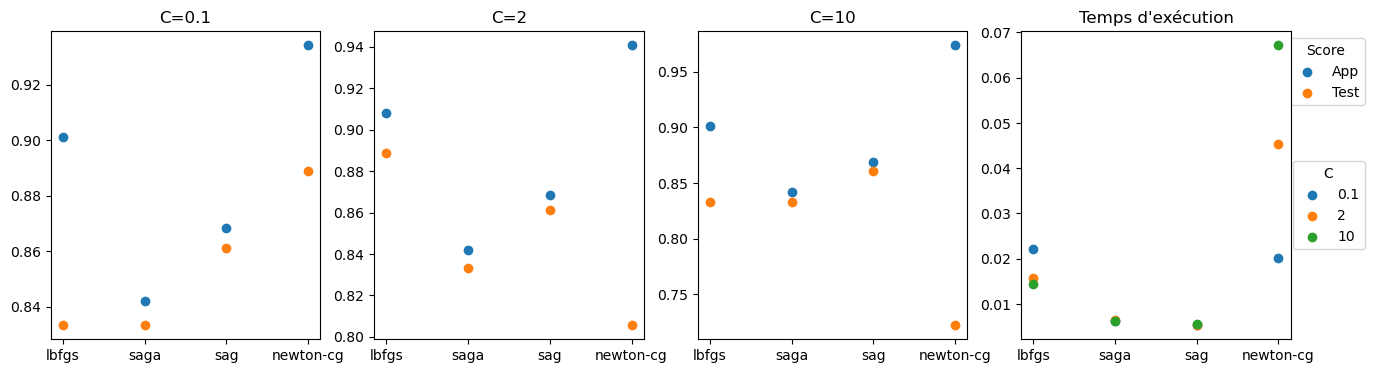

In [256]:
result = result_brute

plt.figure(figsize=(16,4))
Clist = [0.1, 2, 10]
for i in range(len(Clist)):
    plt.subplot(1,4,i+1)
    plt.scatter(result[result.C==Clist[i]].opti, result[result.C==Clist[i]].score_app, label="App")
    plt.scatter(result[result.C==Clist[i]].opti, result[result.C==Clist[i]].score_test, label="Test")
    plt.title('C='+str(Clist[i]))

plt.legend(title = "Score",bbox_to_anchor =(2.5, 1))

plt.subplot(1,4,i+2)
for i in Clist : 
    plt.scatter(result[result.C==i].opti, result[result.C==i].time_ex, label = i)
plt.title("Temps d'exécution")
plt.legend(title = "C",bbox_to_anchor =(1.3, 0.6))
plt.savefig('RegLog_modele_time.png')
plt.show()

In [257]:
opt_list = ['lbfgs', 'saga', 'sag', 'newton-cg', 'liblinear']
experiences = {'opti':opt_list, 'C': [0.1, 0.5, 1, 2, 5, 10, 15]}
dfexp = pd.DataFrame(list(itertools.product(*experiences.values())), columns=experiences.keys())

result_brute = exp_Logist(dfexp, BaseApp, BaseTest, "ovr")
[solver_best_logreg_ovr, C_best_logreg_ovr] = best_model(result_brute)
print("Best : ", solver_best_logreg_ovr, " / ",C_best_logreg_ovr)

Best :  lbfgs  /  0.1


On peut comparer les résultats pour un modèle ``binomial`` ou un modèle ``multinomial`` : 

In [258]:
best_Logist_ovr = LogisticRegression(solver = solver_best_logreg_ovr, C=C_best_logreg_ovr,fit_intercept = False, multi_class="ovr", random_state=0).fit(BaseApp, LabelApp)
best_scoreApp_Logist_ovr = best_Logist_ovr.score(BaseApp, LabelApp)
best_scoreTest_Logist_ovr = best_Logist_ovr.score(BaseTest, LabelTest)
print("Modèle Binomial : Sur les données brutes : App = ",best_scoreApp_Logist_ovr, " / Test = ", best_scoreTest_Logist_ovr)

best_Logist = LogisticRegression(solver = solver_best_logreg, C=C_best_logreg,fit_intercept = False,multi_class="multinomial", random_state=0).fit(BaseApp, LabelApp)
best_scoreApp_Logist = best_Logist.score(BaseApp, LabelApp)
best_scoreTest_Logist = best_Logist.score(BaseTest, LabelTest)
print("Modèle Multinomial : Sur les données brutes : App = ",best_scoreApp_Logist, " / Test = ", best_scoreTest_Logist)

Modèle Binomial : Sur les données brutes : App =  0.8947368421052632  / Test =  0.8888888888888888
Modèle Multinomial : Sur les données brutes : App =  0.9078947368421053  / Test =  0.8888888888888888


Les résultats sont mieux dans le cas de la Régression Multinomiale.

###  Evaluation des résultats 

On évalue le meilleur modèle choisi sur les bases de données: brute, normalisée et avec PCA et on compare les résultats :

Visualisons les courbes ROC des prédictions :

In [259]:
def ROC(BaseTest, classes, y_proba, name) :
    roc_auc_ovr = {}
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame(BaseTest.copy())
        df_aux['class'] = [1 if y == c else 0 for y in LabelTest]
        df_aux['prob'] = y_proba[:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = metrics.roc_curve(df_aux['class'], df_aux['prob'])
        # tpr, fpr, thresholds = metrics.roc_curve(df_aux['class'], df_aux['prob'])
        roc_auc_ovr[c] = metrics.roc_auc_score(df_aux['class'], df_aux['prob'])
        plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label = f"Class: {int(c)} : AUC = {roc_auc_ovr[c]}")    
        plt.plot(nn_fpr_keras, nn_fpr_keras, c = 'gray')
        # Calculates the ROC AUC OvR
        
    plt.legend()#fontsize = size_legend)
    plt.title("Courbe ROC") # fontsize = size_legend+2)
    plt.xlabel("False Positive") # fontsize = size_legend+1)
    plt.ylabel("True Positive") # fontsize = size_legend+1)
    plt.savefig(name)
    plt.show()

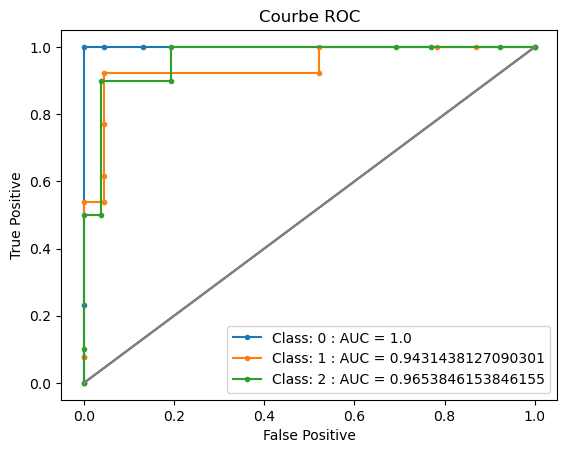

In [260]:
ROC(BaseTest, best_Logist.classes_, best_Logist.predict_proba(BaseTest), 'RegLog_ROC.png')

Sur les données brutes : App =  0.9078947368421053  / Test =  0.8888888888888888
Sur les données réduites par PCA : App =  0.42105263157894735  / Test =  0.3055555555555556
Sur les données normalisées : App =  0.9144736842105263  / Test =  0.8888888888888888


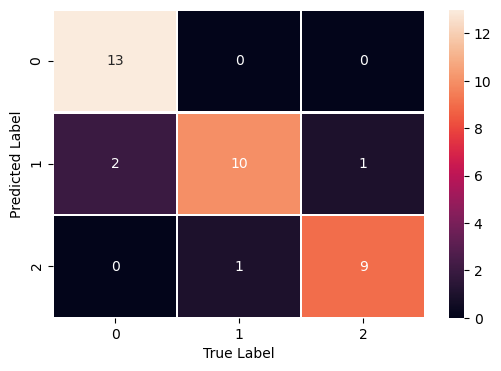

In [261]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn import metrics

# best_Logist = LogisticRegression(solver = solver_best_logreg, C=C_best_logreg,fit_intercept = False, random_state=0).fit(BaseApp, LabelApp)
best_scoreApp_Logist = best_Logist.score(BaseApp, LabelApp)
best_scoreTest_Logist = best_Logist.score(BaseTest, LabelTest)
print("Sur les données brutes : App = ",best_scoreApp_Logist, " / Test = ", best_scoreTest_Logist)

best_Logist_pca = LogisticRegression(solver = solver_best_logreg, C=C_best_logreg,fit_intercept = False, random_state=0).fit(BaseApp_pca, LabelApp)
best_scoreApp_Logist_pca = best_Logist_pca.score(BaseApp_pca, LabelApp)
best_scoreTest_Logist_pca = best_Logist_pca.score(BaseTest_pca, LabelTest)
print("Sur les données réduites par PCA : App = ",best_scoreApp_Logist_pca, " / Test = ", best_scoreTest_Logist_pca)

best_Logist_scale = LogisticRegression(solver = solver_best_logreg, C=C_best_logreg,fit_intercept = False, random_state=0).fit(BaseApp_scale, LabelApp)
best_scoreApp_Logist_scale = best_Logist_scale.score(BaseApp_scale, LabelApp)
best_scoreTest_Logist_scale = best_Logist_scale.score(BaseTest_scale, LabelTest)
print("Sur les données normalisées : App = ", best_scoreApp_Logist_scale, " / Test = ", best_scoreTest_Logist_scale)

plt.figure(figsize=(6,4))
y_pred = best_Logist.predict(BaseTest)
sns.heatmap(metrics.confusion_matrix(LabelTest, y_pred), linewidth = 1 , annot = True)
plt.xlabel("True Label") # fontsize = size_legend+2)
plt.ylabel("Predicted Label") # fontsize = size_legend+2)
plt.savefig('RegLog_confusion.png')
plt.show()

- Nous remarquons que l'évaluation du meilleur modèle de regression logistique donne des scores semblables pour les données brutes et normalisées et un très inférieur pour la base de données avec ACP 

- On conclue alors que la réduction de dimension dans ce cas en utilisant l'ACP n'est pas adaptée, car les dimensions de notre base de donnée brute ne sont pas assez grandes pour effectuer cette transformation, donc la qualité de prédiction ne fait que diminuer en réduisant davantage les dimensions.


# Partie II : Classification par méthodes à noyau

Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou les donnés pourront être séparé linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 

### 1. Réaliser une classification par SVM à noyau


In [262]:
from sklearn.svm import SVC
# SVC : 
# C : regularization parameter (0.1 et 1)
# kernel : 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
experiences = {'kernel':kernel_list, 'C': [0.1, 0.5, 1, 2, 5, 10, 15]}
dfexp = pd.DataFrame(list(itertools.product(*experiences.values())), columns=experiences.keys())

# calcul du score pour chaque expérience :
def exp_SVC(row, BaseApp, BaseTest):
    df = row.copy()
    # 1rt column = score app
    # 2nd column = score test
    # 3rd column = time of execution
    result = np.zeros((np.shape(df)[0],3))
    for i in range(np.shape(df)[0]):
        t1 = time.time()
        model = SVC(kernel = df.kernel[i], C=df.C[i],random_state=0)
        model.fit(BaseApp, LabelApp)
        t2 = time.time()
        result[i,0] = model.score(BaseApp, LabelApp)
        result[i,1] = model.score(BaseTest, LabelTest)
        result[i,2] = t2-t1

    df[['score_app']] = pd.DataFrame(result[:,0])
    df[['score_test']] = pd.DataFrame(result[:,1])
    df[['time_ex']] = pd.DataFrame(result[:,2])
    return df


def aff_SVC(result) :
    print(result.sort_values(by = 'score_test', ascending = False))
    plt.figure(figsize=(12,6))
    Clist = np.unique(result.C)
    for i in range(len(Clist)):
        plt.subplot(2,4,i+1)
        plt.scatter(result[result.C==Clist[i]].kernel, result[result.C==Clist[i]].score_app, label="Score App")
        plt.scatter(result[result.C==Clist[i]].kernel, result[result.C==Clist[i]].score_test, label="Score Test")
        plt.title('C='+str(Clist[i])) #fontsize = size_legend)
    plt.legend(loc = "best") # fontsize = size_legend)
    plt.savefig('SVC_modele.png')
    plt.show()

Best :  poly  /  5.0
     kernel     C  score_app  score_test   time_ex      diff
2    linear   1.0   1.000000    0.805556  0.028394  0.194444
3    linear   2.0   1.000000    0.805556  0.032105  0.194444
4    linear   5.0   1.000000    0.805556  0.029291  0.194444
5    linear  10.0   1.000000    0.805556  0.025596  0.194444
6    linear  15.0   1.000000    0.805556  0.025378  0.194444
1    linear   0.5   1.000000    0.805556  0.027460  0.194444
0    linear   0.1   0.986842    0.777778  0.017069  0.209064
11     poly   5.0   0.789474    0.750000  0.001372  0.039474
20      rbf  15.0   0.842105    0.722222  0.001292  0.119883
19      rbf  10.0   0.822368    0.722222  0.001342  0.100146
12     poly  10.0   0.835526    0.722222  0.001436  0.113304
9      poly   1.0   0.677632    0.694444  0.001429 -0.016813
10     poly   2.0   0.717105    0.694444  0.001380  0.022661
13     poly  15.0   0.855263    0.666667  0.001511  0.188596
18      rbf   5.0   0.789474    0.666667  0.001333  0.122807
8  

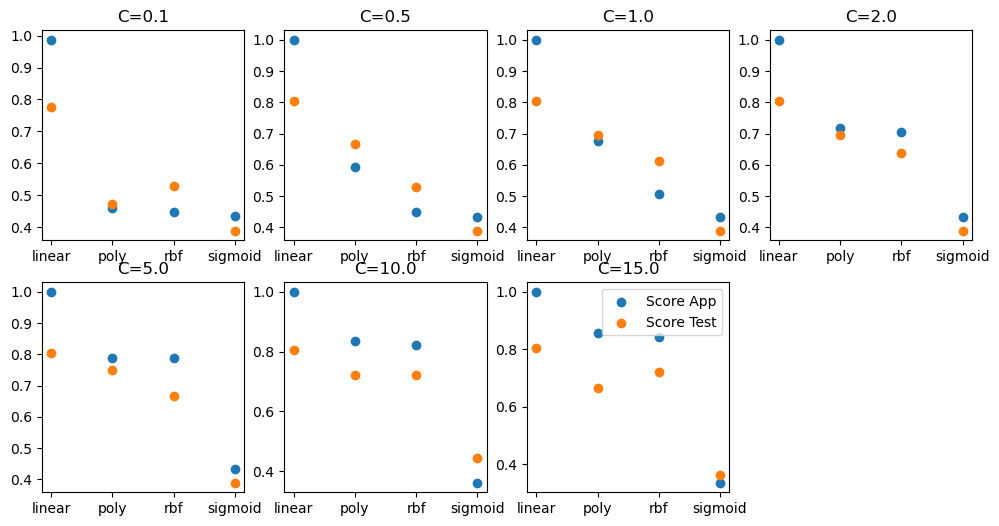

In [263]:
result_SVC = exp_SVC(dfexp, BaseApp, BaseTest)

[kernel_best_SVC, C_best_SVC] = best_model(result_SVC)
print("Best : ", kernel_best_SVC, " / ",C_best_SVC)

model_best_SVC = SVC(kernel = kernel_best_SVC, C=C_best_SVC, random_state=123)
model_best_SVC.fit(BaseApp, LabelApp)

aff_SVC(result_SVC)

In [264]:
# Comparaison des scores sur les différentes bases de données : 
best_SVC = SVC(kernel = kernel_best_SVC, C=C_best_SVC, random_state=0, probability = True).fit(BaseApp, LabelApp)
best_scoreApp_SVC = best_SVC.score(BaseApp, LabelApp)
best_scoreTest_SVC = best_SVC.score(BaseTest, LabelTest)
print("Sur les données brutes : App = ",best_scoreApp_SVC, " / Test = ", best_scoreTest_SVC)

best_SVC_pca = SVC(kernel = kernel_best_SVC, C=C_best_SVC, random_state=0, probability = True).fit(BaseApp_pca, LabelApp)
best_scoreApp_SVC_pca = best_SVC_pca.score(BaseApp_pca, LabelApp)
best_scoreTest_SVC_pca = best_SVC_pca.score(BaseTest_pca, LabelTest)
print("Sur les données réduites par PCA : App = ",best_scoreApp_SVC_pca, " / Test = ", best_scoreTest_SVC_pca)

best_SVC_scale = SVC(kernel = kernel_best_SVC, C=C_best_SVC, random_state=0, probability = True).fit(BaseApp_scale, LabelApp)
best_scoreApp_SVC_scale = best_SVC_scale.score(BaseApp_scale, LabelApp)
best_scoreTest_SVC_scale = best_SVC_scale.score(BaseTest_scale, LabelTest)
print("Sur les données normalisées : App = ", best_scoreApp_SVC_scale, " / Test = ", best_scoreTest_SVC_scale)

Sur les données brutes : App =  0.7894736842105263  / Test =  0.75
Sur les données réduites par PCA : App =  0.47368421052631576  / Test =  0.4166666666666667
Sur les données normalisées : App =  0.9736842105263158  / Test =  0.7777777777777778


- Bons scores d'apprentissage et de test sur les données non normalisées, les deux scores sont rapprochés : pas de surapprentissage

- les scores pour les données réduit avec ACP ne sont pas satisfaisants

- surapprentissage sur les données normalisées vu l'écart d'environ 0.2 entre le score d'apprentissage et de test

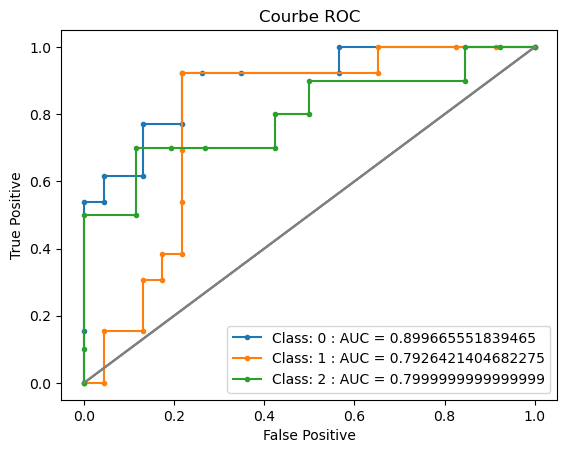

In [265]:
ROC(BaseTest, best_SVC.classes_, best_SVC.predict_proba(BaseTest), "SVC_ROC.png")

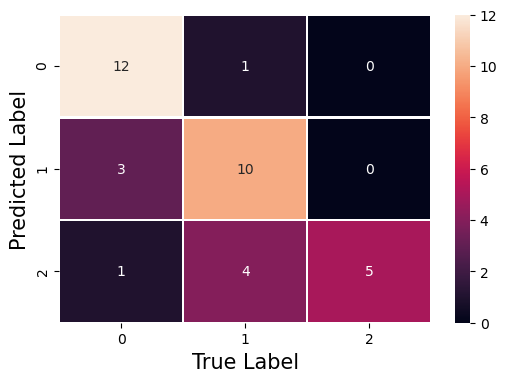

In [266]:
plt.figure(figsize=(6,4))
y_pred = model_best_SVC.predict(BaseTest)
sns.heatmap(metrics.confusion_matrix(LabelTest, y_pred), linewidth = 1 , annot = True)
plt.xlabel("True Label", fontsize = size_legend)
plt.ylabel("Predicted Label", fontsize = size_legend)
plt.savefig('SVC_confusion.png')
plt.show()

- Le label 2 est prédit correctement

- classification moins bonne pour les labels 0 et 1 mais plutôt satisfaisante 


### Approche non supervisée :  Classification spectrale 

 On peut aussi transposer à l'espace de Hilbert $\mathcal{H}$ des algos classiques de $\mathbb{R}^d$ comme la Classification spectrale.
 
Ici il s'agit d'une classification non supervisée. Le modèle ne sera donc pas capable d'associer le bon label à la classification. On ne pourra pas reconnaître les ordres pour le drone.

- Optimisation du modèle Spectral Clustering :

In [267]:
from sklearn.cluster import SpectralClustering

# n_clusters
# eigen_solver : 'arpack', 'lobpcg', 'amg'
# n_init : number of time the k-means algorithm will be run with different centroid seeds. default=10
# gamma : default=1, 
# assign_labels : 'kmeans', 'discretize', 'cluster_qr'

eigen_solver = ['arpack','lobpcg'] 
experiences = {'eigen':eigen_solver, 'assign_labels' : ['kmeans', 'discretize']}

dfexp = pd.DataFrame(list(itertools.product(*experiences.values())), columns=experiences.keys())

# calcul du score pour chaque expérience :
def exp_SpectralClustering(row, App, Test):
    df = row.copy()
    # 1rt column = score app
    # 2nd column = score test
    # 3rd column = time of execution
    result = np.zeros((np.shape(df)[0],3))
    for i in range(np.shape(df)[0]):
        # print("i = ", i, df.eigen[i], df.assign_labels[i])
        t1 = time.time()
        model = SpectralClustering(n_clusters=len(np.unique(LabelApp)), eigen_solver = df.eigen[i], 
                assign_labels= df.assign_labels[i], random_state=0).fit(App)
        pred = SpectralClustering(n_clusters=len(np.unique(LabelApp)), eigen_solver = df.eigen[i], 
                assign_labels= df.assign_labels[i], random_state=0).fit_predict(Test)
        t2 = time.time()
        result[i,0] = accuracy_score(LabelApp, model.labels_)
        result[i,1] = accuracy_score(LabelTest, pred)
        result[i,2] = t2-t1

    df[['score_app']] = pd.DataFrame(result[:,0])
    df[['score_test']] = pd.DataFrame(result[:,1])
    df[['time_ex']] = pd.DataFrame(result[:,2])
    return df

In [268]:
result_SpectClust = exp_SpectralClustering(dfexp, BaseApp, BaseTest)
print(result_SpectClust.sort_values(by = 'score_test', ascending = False))

[eigen_best, assign_labels_best] = best_model(result_SpectClust)
print("Best : ", eigen_best, " / ",assign_labels_best)
model_best_SpectClust = SpectralClustering(n_clusters= len(np.unique(LabelApp)), eigen_solver = eigen_best, assign_labels= assign_labels_best, random_state=0).fit(BaseApp)

    eigen assign_labels  score_app  score_test   time_ex
3  lobpcg    discretize   0.381579    0.472222  0.008945
1  arpack    discretize   0.309211    0.444444  0.007569
0  arpack        kmeans   0.269737    0.361111  0.022043
2  lobpcg        kmeans   0.269737    0.361111  0.020448
Attention au sur-apprentissage
Best :  lobpcg  /  discretize


Sur les données brutes : App =  0.29605263157894735  / Test =  0.3055555555555556
Sur les données réduites par PCA : App =  0.35526315789473684  / Test =  0.3888888888888889
Sur les données normalisées : App =  0.3618421052631579  / Test =  0.3888888888888889


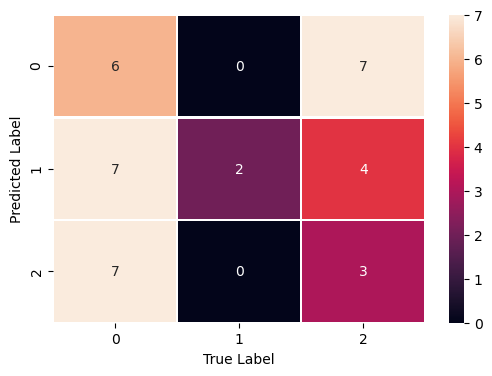

In [269]:
# Comparaison des scores sur les différentes bases de données : 
best_SpectClust = SpectralClustering(n_clusters=len(np.unique(LabelApp)),eigen_solver = eigen_best,assign_labels= assign_labels_best,random_state=123).fit(BaseApp)
best_scoreApp_SpectClust = accuracy_score(best_SpectClust.fit_predict(BaseApp), LabelApp)
best_scoreTest_SpectClust = accuracy_score(best_SpectClust.fit_predict(BaseTest), LabelTest)
print("Sur les données brutes : App = ",best_scoreApp_SpectClust, " / Test = ", best_scoreTest_SpectClust)

best_SpectClust_pca = SpectralClustering(n_clusters=len(np.unique(LabelApp)),eigen_solver = eigen_best,assign_labels= assign_labels_best,random_state=123).fit(BaseApp_pca)
best_scoreApp_SpectClust_pca = accuracy_score(best_SpectClust_pca.fit_predict(BaseApp_pca), LabelApp)
best_scoreTest_SpectClust_pca = accuracy_score(best_SpectClust_pca.fit_predict(BaseTest_pca), LabelTest)
print("Sur les données réduites par PCA : App = ",best_scoreApp_SpectClust_pca, " / Test = ", best_scoreTest_SpectClust_pca)

best_SpectClust_scale = SpectralClustering(n_clusters=len(np.unique(LabelApp)),eigen_solver = eigen_best,assign_labels= assign_labels_best,random_state=123).fit(BaseApp_scale)
best_scoreApp_SpectClust_scale = accuracy_score(best_SpectClust_scale.fit_predict(BaseApp_scale), LabelApp)
best_scoreTest_SpectClust_scale = accuracy_score(best_SpectClust_scale.fit_predict(BaseTest_scale), LabelTest)
print("Sur les données normalisées : App = ", best_scoreApp_SpectClust_scale, " / Test = ", best_scoreTest_SpectClust_scale)

plt.figure(figsize=(6,4))
y_pred = best_SpectClust.fit_predict(BaseTest)
sns.heatmap(metrics.confusion_matrix(LabelTest, y_pred), linewidth = 1 , annot = True)
plt.xlabel("True Label") # fontsize = size_legend)
plt.ylabel("Predicted Label") # fontsize = size_legend)
plt.savefig('SpectClust_confusion.png')
plt.show()

- Scores non satisfaisants du modèle de Classification Spectrale appliquée aux 3 types de données
- on obtient des scores tests meilleurs que les scores d'apprentissage : il peut s'agir d'un sous-apprentissage. On pourrait aussi essayer d'écrire des intervalles de confiance pour ces scores.

# Partie III : Apprentissage par ensemble 

## 1. Adaptive Boosting : AdaBoost 

Adaboost repose sur la sélection itérative de classifieur faible en fonction d'une distribution des exemples d'apprentissage. Chaque exemple est pondéré en fonction de sa difficulté avec le classifieur courant. 

In [270]:
from sklearn.ensemble import AdaBoostClassifier

# n_estimators : [1, inf[ default=50
# learning_rate : [0, inf[ default=1

experiences = {'n_est':np.linspace(1,100,20), 'LR' : np.linspace(0.001,5,20)}
dfexp = pd.DataFrame(list(itertools.product(*experiences.values())), columns=experiences.keys())

# calcul du score pour chaque expérience :
def exp_AdaBoost(row, App, Test):
    df = row.copy()
    # 1rt column = score app
    # 2nd column = score test
    # 3rd column = time of execution
    result = np.zeros((np.shape(df)[0],3))
    for i in range(np.shape(df)[0]):
        t1 = time.time()
        # (n_clusters=len(unique(Label3))).fit(BaseApp)
        abc = AdaBoostClassifier(n_estimators=int(df.n_est[i]), learning_rate=df.LR[i], random_state=0)
        abc.fit(App, LabelApp)
        t2 = time.time()
        result[i,0] = abc.score(App, LabelApp)
        result[i,1] = abc.score(Test, LabelTest)
        result[i,2] = t2-t1

    df[['score_app']] = pd.DataFrame(result[:,0])
    df[['score_test']] = pd.DataFrame(result[:,1])
    df[['time_ex']] = pd.DataFrame(result[:,2])
    return df

In [271]:
result_AdaBoost = exp_AdaBoost(dfexp, BaseApp, BaseTest)
print(result_AdaBoost.sort_values(by = ['score_test','score_app','time_ex'], ascending = [False,False,True], ignore_index = True))

[n_est_best, LR_best] = best_model(result_AdaBoost)
n_est_best = int(n_est_best)
print("Best : ", n_est_best, " / ",LR_best)

model_best_AdaBoost = AdaBoostClassifier(n_estimators = n_est_best, learning_rate= LR_best, random_state=0)
model_best_AdaBoost.fit(BaseApp, LabelApp)

          n_est        LR  score_app  score_test   time_ex
0    100.000000  2.895158   0.822368    0.750000  0.094899
1     79.157895  1.053421   0.980263    0.722222  0.067507
2     53.105263  1.053421   0.973684    0.722222  0.045478
3     47.894737  1.053421   0.973684    0.722222  0.047125
4     47.894737  0.790316   0.934211    0.722222  0.041687
..          ...       ...        ...         ...       ...
395   42.684211  4.210684   0.315789    0.194444  0.031187
396   63.526316  4.210684   0.315789    0.194444  0.044049
397   84.368421  4.210684   0.315789    0.194444  0.057267
398   27.052632  2.632053   0.342105    0.166667  0.023377
399   21.842105  2.632053   0.335526    0.111111  0.018180

[400 rows x 5 columns]
Best :  100  /  2.8951578947368417


AdaBoostClassifier(learning_rate=2.8951578947368417, n_estimators=100,
                   random_state=0)

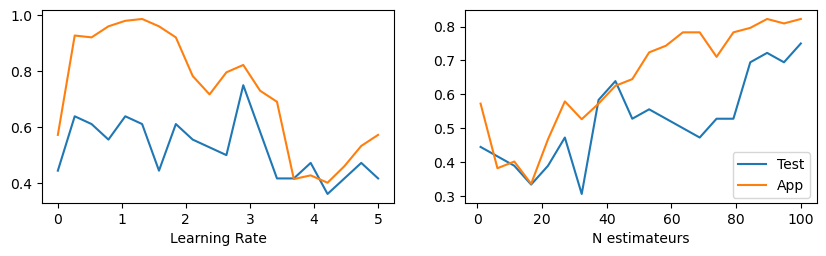

In [272]:
# plot score en fonction de LR 
g = result_AdaBoost.loc[((result_AdaBoost.n_est > n_est_best -1) & (result_AdaBoost.n_est < n_est_best +1)),:]
plt.figure(figsize=(10,2.5))
plt.subplot(1,2,1)
plt.plot(g.LR, g.score_test, label = "Test")
plt.plot(g.LR, g.score_app, label = "App")
plt.xlabel("Learning Rate")

# plot score en fonction de n_best 
g = result_AdaBoost.loc[result_AdaBoost.LR == LR_best,:]
plt.subplot(1,2,2)
plt.plot(g.n_est, g.score_test, label = "Test")
plt.plot(g.n_est, g.score_app, label = "App")
plt.xlabel("N estimateurs")
plt.legend(bbox_to_anchor =(1, 0.3))
plt.savefig("AdaBoost_n_LR.png")
plt.show()

Sur les données brutes : App =  0.8223684210526315  / Test =  0.75
Sur les données réduites par ACP : App =  0.5526315789473685  / Test =  0.4444444444444444
Sur les données normalisées : App =  0.8223684210526315  / Test =  0.7222222222222222


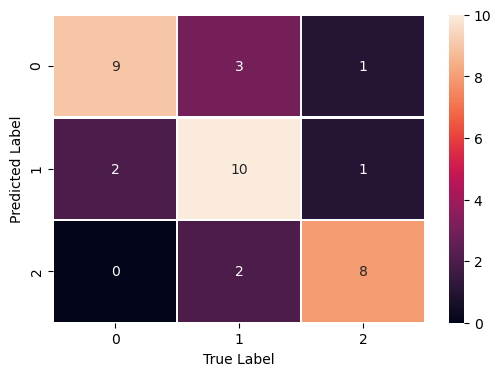

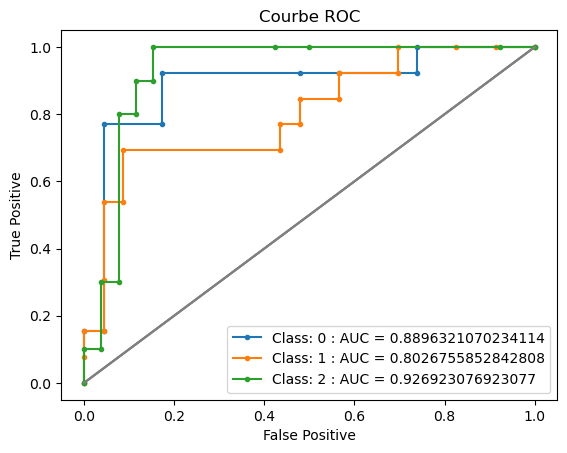

In [273]:
best_AdaBoost = AdaBoostClassifier(n_estimators=n_est_best, learning_rate=LR_best, random_state=0)
best_AdaBoost.fit(BaseApp, LabelApp)
print("Sur les données brutes : App = ", best_AdaBoost.score(BaseApp, LabelApp), " / Test = ", best_AdaBoost.score(BaseTest, LabelTest))

best_AdaBoost_pca = AdaBoostClassifier(n_estimators=n_est_best, learning_rate=LR_best, random_state=0)
best_AdaBoost_pca.fit(BaseApp_pca, LabelApp)
print("Sur les données réduites par ACP : App = ", best_AdaBoost_pca.score(BaseApp_pca, LabelApp), " / Test = ", best_AdaBoost_pca.score(BaseTest_pca, LabelTest))

best_AdaBoost_scale = AdaBoostClassifier(n_estimators=n_est_best, learning_rate=LR_best, random_state=0)
best_AdaBoost_scale.fit(BaseApp_scale, LabelApp)
print("Sur les données normalisées : App = ", best_AdaBoost_scale.score(BaseApp_scale, LabelApp), " / Test = ", best_AdaBoost_scale.score(BaseTest_scale, LabelTest))

plt.figure(figsize=(6,4))
y_pred = best_AdaBoost.predict(BaseTest)
sns.heatmap(metrics.confusion_matrix(LabelTest, y_pred), linewidth = 1 , annot = True)
plt.xlabel("True Label") # fontsize = size_legend)
plt.ylabel("Predicted Label") # fontsize = size_legend)
plt.savefig('AdaBoost_confusion.png')
plt.show()

ROC(BaseTest, best_AdaBoost.classes_, best_AdaBoost.predict_proba(BaseTest),'AdaBoost_ROC.png')

  

- Nous obtenons un meilleur score sur la base de données brute que sur les données normalisées ou encore avec ACP.



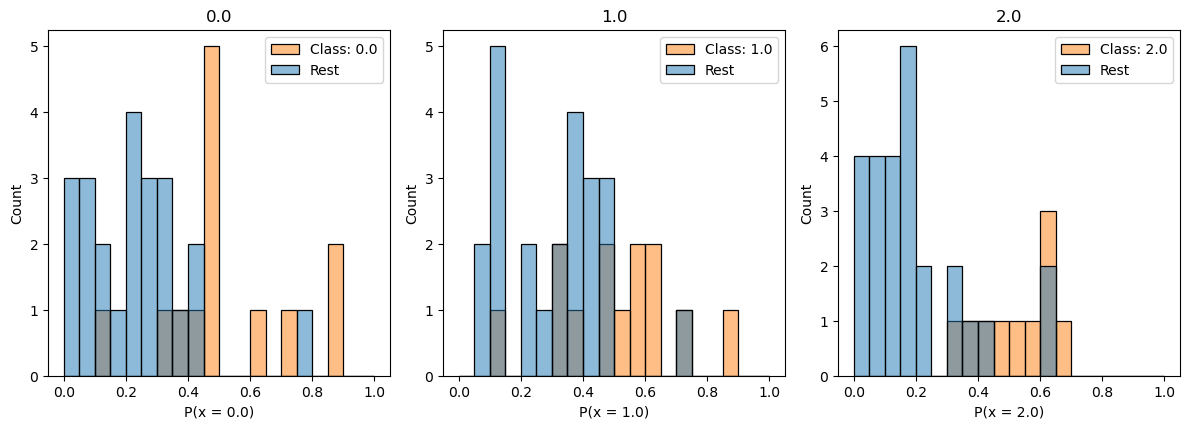

In [274]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]

classes = best_AdaBoost.classes_
y_proba = best_AdaBoost.predict_proba(BaseTest)
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(BaseTest.copy())
    df_aux['class'] = [1 if y == c else 0 for y in LabelTest]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
plt.tight_layout()

## 2. Gradient Boosting

Le Gradient Boosting permet l'optimisation de fonctions de perte différentiables arbitraires. Il permet d'optimiser la fonction de perte de l'apprenant précédent en ajoutant un nouveau modèle adaptatif qui combine des apprenants faibles.

In [275]:
from numba.core.types.containers import ListTypeIterableType
from sklearn.ensemble import GradientBoostingClassifier

# GradientBoostingClassifier
# n_est : 
# loss : 'deviance', 'exponential' ('exponential' ne marche que pour 2 classes)
# learning_rate : default=1, [0,inf] controls how fast the model learns
# criterion : 'friedman_mse', 'squared_error', 'mse'

experiences = {'LR' : np.linspace(0.01,1,15), 'max_depth' : [1,2,3,4,5,6,7]} 
dfexp = pd.DataFrame(list(itertools.product(*experiences.values())), columns=experiences.keys())

# calcul du score pour chaque expérience :
def exp_GradientBoosting(row, Base, Test):
    df = row.copy()
    # 1st column = score app
    # 2nd column = score test
    # 3rd column = time of execution
    result = np.zeros((np.shape(df)[0],3))
    for i in range(np.shape(df)[0]):
        t1 = time.time()
        clf = GradientBoostingClassifier(learning_rate=df.LR[i],max_depth=df.max_depth[i], random_state=0)
        clf.fit(Base, LabelApp)
        t2 = time.time()
        result[i,0] = clf.score(Base, LabelApp)
        result[i,1] = clf.score(Test, LabelTest)
        result[i,2] = t2-t1

    df[['score_app']] = pd.DataFrame(result[:,0])
    df[['score_test']] = pd.DataFrame(result[:,1])
    df[['time_ex']] = pd.DataFrame(result[:,2])
    return df

In [276]:
result_GradientBoosting = exp_GradientBoosting(dfexp, BaseApp, BaseTest)
print(result_GradientBoosting)
print(result_GradientBoosting.sort_values(by = ['score_test','score_app','time_ex'], ascending = [False,False,True], ignore_index = True))

[LR_best, max_depth_best] = best_model(result_GradientBoosting)
print("Best : ", LR_best, " / ", max_depth_best)

       LR  max_depth  score_app  score_test   time_ex
0    0.01          1   0.671053    0.444444  0.128775
1    0.01          2   0.894737    0.694444  0.191404
2    0.01          3   0.973684    0.583333  0.252650
3    0.01          4   0.993421    0.583333  0.350548
4    0.01          5   1.000000    0.583333  0.442319
..    ...        ...        ...         ...       ...
100  1.00          3   1.000000    0.694444  0.278841
101  1.00          4   1.000000    0.666667  0.355545
102  1.00          5   1.000000    0.694444  0.440663
103  1.00          6   1.000000    0.694444  0.539290
104  1.00          7   1.000000    0.611111  0.592728

[105 rows x 5 columns]
           LR  max_depth  score_app  score_test   time_ex
0    0.363571          2   1.000000    0.722222  0.206758
1    0.363571          3   1.000000    0.722222  0.279009
2    0.505000          3   1.000000    0.722222  0.279724
3    0.929286          4   1.000000    0.722222  0.355669
4    0.646429          4   1.000000   

In [277]:
print(result_GradientBoosting.sort_values(by = ['score_test','score_app','time_ex'], ascending = [False,False,True], ignore_index = True))

           LR  max_depth  score_app  score_test   time_ex      diff
0    0.363571          2   1.000000    0.722222  0.206758  0.277778
1    0.363571          3   1.000000    0.722222  0.279009  0.277778
2    0.505000          3   1.000000    0.722222  0.279724  0.277778
3    0.929286          4   1.000000    0.722222  0.355669  0.277778
4    0.646429          4   1.000000    0.722222  0.358923  0.277778
..        ...        ...        ...         ...       ...       ...
100  0.080714          7   1.000000    0.527778  0.574477  0.472222
101  0.010000          7   1.000000    0.527778  0.605791  0.472222
102  0.858571          7   1.000000    0.527778  0.608727  0.472222
103  0.010000          6   1.000000    0.500000  0.505992  0.500000
104  0.010000          1   0.671053    0.444444  0.128775  0.226608

[105 rows x 6 columns]


### Evaluation de la classification

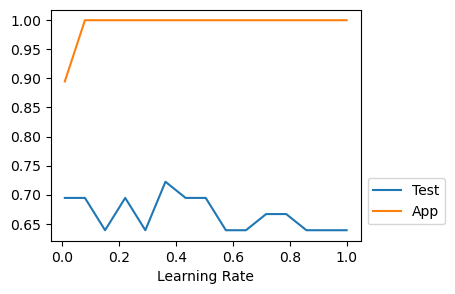

In [278]:
# plot score en fonction de LR 
g = result_GradientBoosting.loc[((result_GradientBoosting.max_depth > max_depth_best -1) & (result_GradientBoosting.max_depth < max_depth_best +1)),:]
plt.figure(figsize=(4,3))
plt.plot(g.LR, g.score_test, label = "Test")
plt.plot(g.LR, g.score_app, label = "App")
plt.xlabel("Learning Rate")
plt.legend(bbox_to_anchor =(1, 0.3))
plt.savefig("GradientBoosting_LR.png")
plt.show()

Sur les données brutes : App =  0.8947368421052632  / Test =  0.6944444444444444
Sur les données réduites par PCA : App =  0.618421052631579  / Test =  0.4166666666666667
Sur les données normalisées : App =  0.8947368421052632  / Test =  0.6944444444444444


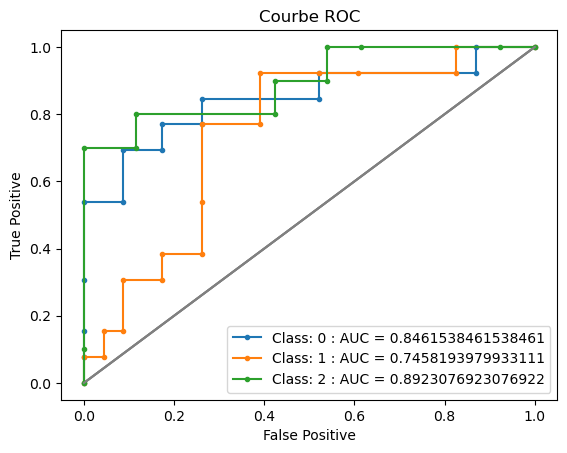

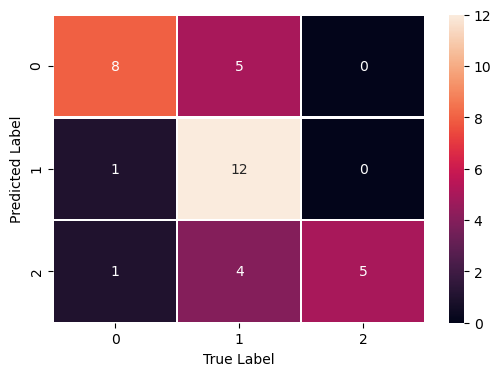

In [279]:
# Comparaison des scores sur les différentes bases de données : 
best_GradientBoosting = GradientBoostingClassifier(learning_rate=LR_best, max_depth=max_depth_best, random_state=0)
best_GradientBoosting.fit(BaseApp, LabelApp)
best_scoreApp_GradientBoosting = best_GradientBoosting.score(BaseApp, LabelApp)
best_scoreTest_GradientBoosting = best_GradientBoosting.score(BaseTest, LabelTest)
print("Sur les données brutes : App = ",best_scoreApp_GradientBoosting, " / Test = ", best_scoreTest_GradientBoosting)

best_GradientBoosting_pca = GradientBoostingClassifier(learning_rate=LR_best, max_depth=max_depth_best, random_state=0)
best_GradientBoosting_pca.fit(BaseApp_pca, LabelApp)
best_scoreApp_GradientBoosting_pca = best_GradientBoosting_pca.score(BaseApp_pca, LabelApp)
best_scoreTest_GradientBoosting_pca = best_GradientBoosting_pca.score(BaseTest_pca, LabelTest)
print("Sur les données réduites par PCA : App = ",best_scoreApp_GradientBoosting_pca, " / Test = ", best_scoreTest_GradientBoosting_pca)

best_GradientBoosting_scale = GradientBoostingClassifier(learning_rate=LR_best, max_depth=max_depth_best, random_state=0)
best_GradientBoosting_scale.fit(BaseApp_scale, LabelApp)
best_scoreApp_GradientBoosting_scale = best_GradientBoosting_scale.score(BaseApp_scale, LabelApp)
best_scoreTest_GradientBoosting_scale = best_GradientBoosting_scale.score(BaseTest_scale, LabelTest)
print("Sur les données normalisées : App = ", best_scoreApp_GradientBoosting_scale, " / Test = ", best_scoreTest_GradientBoosting_scale)

ROC(BaseTest, best_GradientBoosting.classes_, best_GradientBoosting.predict_proba(BaseTest),'GradientBoost_ROC.png')

plt.figure(figsize=(6,4))
pred = best_GradientBoosting.predict(BaseTest)
sns.heatmap(metrics.confusion_matrix(LabelTest, pred), linewidth = 1 , annot = True)
plt.xlabel("True Label") # fontsize = size_legend)
plt.ylabel("Predicted Label") # fontsize = size_legend)
plt.savefig('GradientBoost_confusion.png')
plt.show()

- Le modèle Gradient Boosting surapprend sur les 3 bases de données différentes (l'écart entre les scores d'apprentissage et de test est grand), donc il est n'est peut être pas adapté à notre étude.

Utilisation de la validation croisée pour évaluer les résultats 

In [280]:
from sklearn.model_selection import cross_val_score

gb = GradientBoostingClassifier(learning_rate=LR_best, max_depth=max_depth_best, random_state=0)
print(cross_val_score(gb, BaseApp, LabelApp))
# par défaut 5-fold : donc renvoie le score sur chaque validation croisée (donc 5 scores)

[0.80645161 0.70967742 0.7        0.56666667 0.6       ]


On retrouve bien dans les scores de crossvalidation que les scores varient beaucoup d'un folf à l'autre.

# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différents solveurs

In [281]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
# MLPClassifier
# activation : 'identity', 'logistic', 'tanh', 'relu'
# solver : 'lbfgs', 'sgd', 'adam'
# learning_rate : 'constant', 'invscaling', 'adaptative'

experiences = {'activation' : ['identity', 'logistic', 'tanh', 'relu'], 
                'solver' : ['sgd', 'adam'], # without 'lbfgs' : because can't print loss_curve 
                'alpha' : [0.0001, 0.001, 0.005, 0.01]} 
dfexp = pd.DataFrame(list(itertools.product(*experiences.values())), columns=experiences.keys())

# calcul du score pour chaque expérience :
def exp_MLPClassifier(row, App, Test):
    df = row.copy()
    # 1rt column = score app
    # 2nd column = score test
    # 3rd column = time of execution
    result = np.zeros((np.shape(df)[0],3))
    for i in range(np.shape(df)[0]):
        t1 = time.time()
        clf = MLPClassifier(activation=df.activation[i], solver=df.solver[i], alpha=df.alpha[i], random_state = 0).fit(App, LabelApp)
        # pred = clf.predict(BaseTest)
        t2 = time.time()
        result[i,0] = clf.score(App, LabelApp)
        result[i,1] = clf.score(Test, LabelTest)
        result[i,2] = t2-t1

    df[['score_app']] = pd.DataFrame(result[:,0])
    df[['score_test']] = pd.DataFrame(result[:,1])
    df[['time_ex']] = pd.DataFrame(result[:,2])
    return df

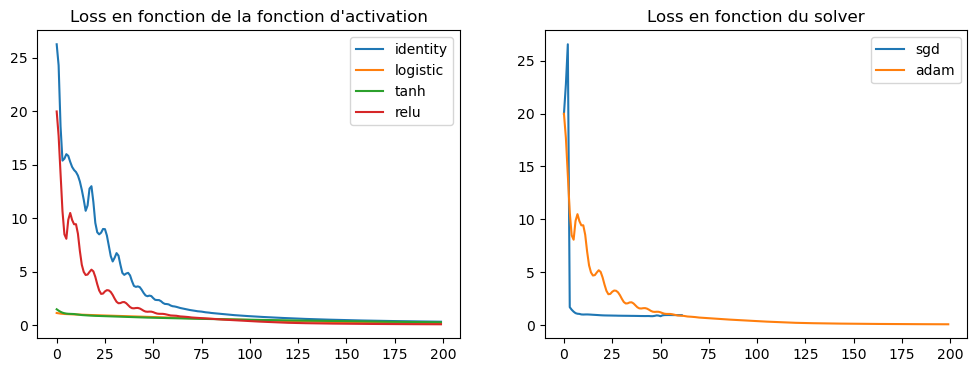

In [282]:
size_legend = 12
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for act in ['identity', 'logistic', 'tanh', 'relu'] : 
    clf = MLPClassifier(activation=act, random_state=0).fit(BaseApp, LabelApp)
    plt.plot(clf.loss_curve_, label = act)
plt.legend() # fontsize=size_legend)
plt.title("Loss en fonction de la fonction d'activation") # fontsize = size_legend+2)

plt.subplot(1,2,2)
for solver in ['sgd', 'adam'] :  # there is no loss_curve with solver = 'lbfgs'
    clf = MLPClassifier(solver = solver, random_state=0).fit(BaseApp, LabelApp)
    plt.plot(clf.loss_curve_, label = solver)
plt.title("Loss en fonction du solver") # fontsize = size_legend+2)
plt.legend() # fontsize=size_legend)

plt.savefig('MLPClassifier_Loss_solver_act.png')
plt.show()

In [283]:
result_MLPClassifier = exp_MLPClassifier(dfexp, BaseApp, BaseTest)
print(result_MLPClassifier.sort_values(by = 'score_test', ascending = False))
[activation_best, solver_best, alpha_best] = best_model(result_MLPClassifier)
print("Best : ", activation_best, " / ", solver_best, " / ", alpha_best)

   activation solver   alpha  score_app  score_test   time_ex
15   logistic   adam  0.0100   1.000000    0.833333  0.103627
4    identity   adam  0.0001   0.881579    0.833333  0.081296
5    identity   adam  0.0010   0.881579    0.833333  0.085128
6    identity   adam  0.0050   0.881579    0.833333  0.078445
7    identity   adam  0.0100   0.881579    0.833333  0.078441
12   logistic   adam  0.0001   0.993421    0.833333  0.109428
13   logistic   adam  0.0010   1.000000    0.833333  0.113183
14   logistic   adam  0.0050   1.000000    0.833333  0.109622
31       relu   adam  0.0100   0.986842    0.777778  0.089160
30       relu   adam  0.0050   0.986842    0.777778  0.089724
23       tanh   adam  0.0100   0.973684    0.777778  0.126620
28       relu   adam  0.0001   0.993421    0.777778  0.088628
29       relu   adam  0.0010   0.986842    0.750000  0.089691
22       tanh   adam  0.0050   0.967105    0.750000  0.128974
21       tanh   adam  0.0010   0.973684    0.750000  0.160838
20      

## Evalution du modèle des Réseaux de Neurone

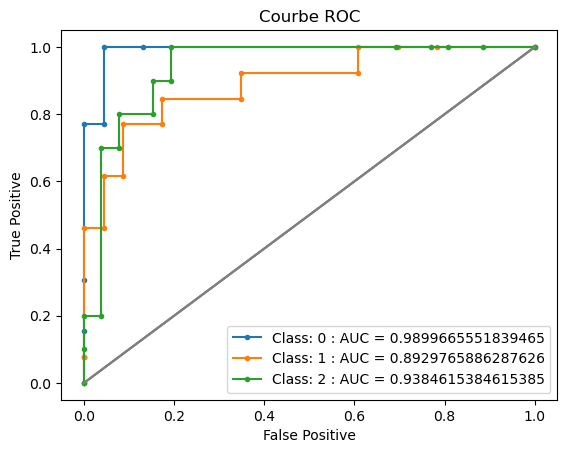

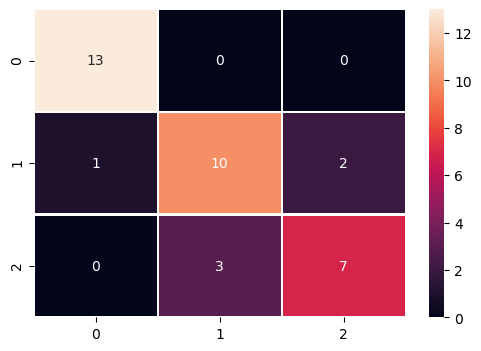

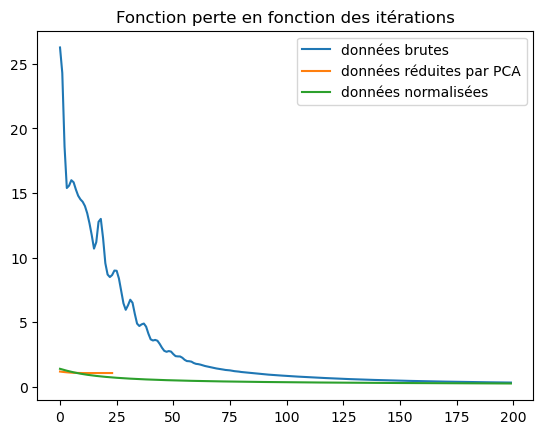

Sur les données brutes : App =  0.881578947368421  / Test =  0.8333333333333334
Sur les données réduites par PCA : App =  0.5  / Test =  0.25
Sur les données normalisées : App =  0.9210526315789473  / Test =  0.8888888888888888


In [284]:
# Comparaison des scores sur les différentes bases de données : 
best_MLPClassifier = MLPClassifier(activation=activation_best, solver=solver_best, alpha = alpha_best, random_state=0).fit(BaseApp, LabelApp)
best_scoreApp_MLPClassifier = best_MLPClassifier.score(BaseApp, LabelApp)
best_scoreTest_MLPClassifier = best_MLPClassifier.score(BaseTest, LabelTest)

best_MLPClassifier_pca = MLPClassifier(activation=activation_best, solver=solver_best, alpha = alpha_best, random_state=0).fit(BaseApp_pca, LabelApp)
best_scoreApp_MLPClassifier_pca = best_MLPClassifier_pca.score(BaseApp_pca, LabelApp)
best_scoreTest_MLPClassifier_pca = best_MLPClassifier_pca.score(BaseTest_pca, LabelTest)

best_MLPClassifier_scale = MLPClassifier(activation=activation_best, solver=solver_best, alpha = alpha_best, random_state=0).fit(BaseApp_scale, LabelApp)
best_scoreApp_MLPClassifier_scale = best_MLPClassifier_scale.score(BaseApp_scale, LabelApp)
best_scoreTest_MLPClassifier_scale = best_MLPClassifier_scale.score(BaseTest_scale, LabelTest)

ROC(BaseTest, best_MLPClassifier.classes_, best_MLPClassifier.predict_proba(BaseTest),'MLPClassifier_ROC.png')

plt.figure(figsize=(6,4))
pred = best_MLPClassifier.predict(BaseTest)
sns.heatmap(metrics.confusion_matrix(LabelTest, pred), linewidth = 1 , annot = True)
plt.savefig('MLPClassifier_confusion.png')
plt.show()

plt.plot(best_MLPClassifier.loss_curve_, label = "données brutes")
plt.plot(best_MLPClassifier_pca.loss_curve_, label = "données réduites par PCA")
plt.plot(best_MLPClassifier_scale.loss_curve_, label = "données normalisées")
plt.title("Fonction perte en fonction des itérations")
plt.legend()
plt.savefig('MLPClassifier_loss.png')
plt.show()

print("Sur les données brutes : App = ",best_scoreApp_MLPClassifier, " / Test = ", best_scoreTest_MLPClassifier)
print("Sur les données réduites par PCA : App = ",best_scoreApp_MLPClassifier_pca, " / Test = ", best_scoreTest_MLPClassifier_pca)
print("Sur les données normalisées : App = ", best_scoreApp_MLPClassifier_scale, " / Test = ", best_scoreTest_MLPClassifier_scale)

- Résultats bons sur les données non normalisées et de meilleurs résultats sur les données normalisées
- Les scores du modèle sur les données réduits avec ACP ne sont pas satisfaisants.  

# Partie V : Comparaison des modèles 

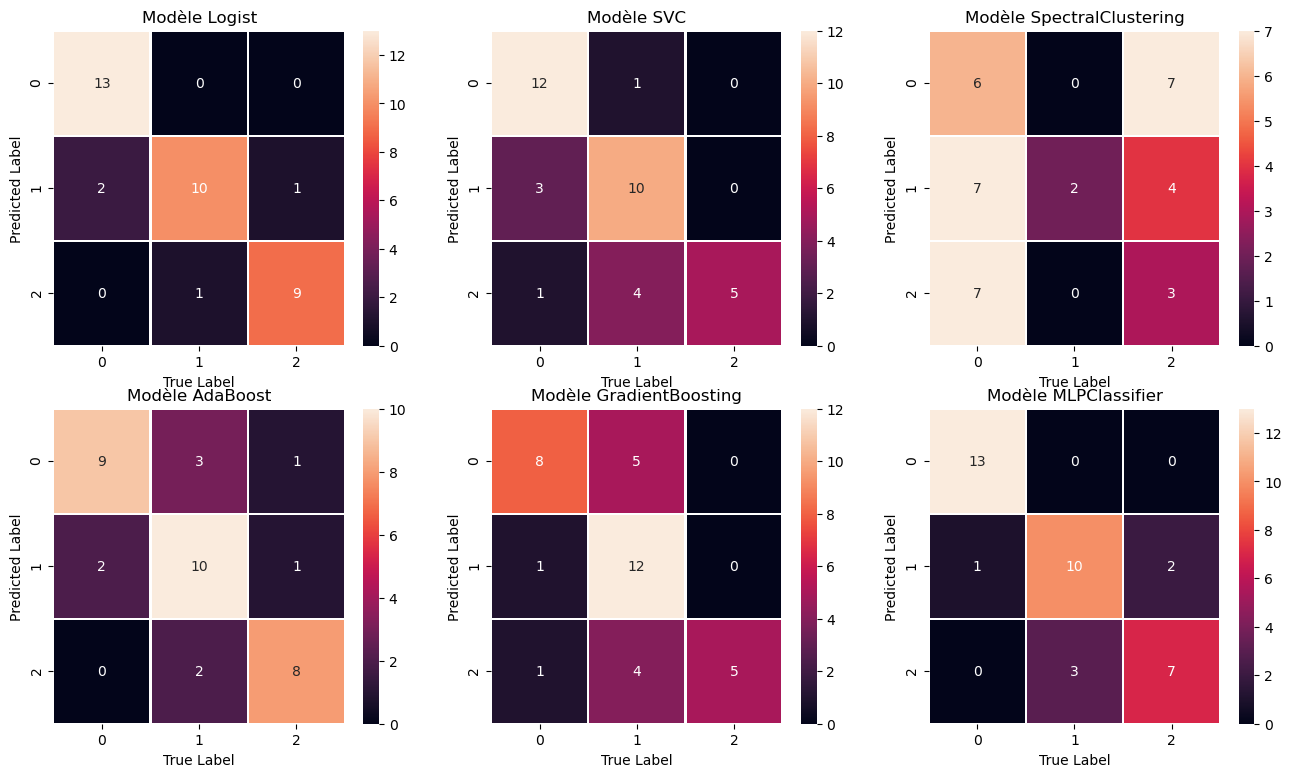

In [285]:
# nombre de modèles : Logist, SVC, SpectralClustering, AdaBoost, GradientBoost, MLPClassifier
pred = np.zeros((6, len(LabelTest)))
pred[0,:] = best_Logist.predict(BaseTest)
pred[1,:] = best_SVC.predict(BaseTest)
pred[2,:] = best_SpectClust.fit_predict(BaseTest)
pred[3,:] = best_AdaBoost.predict(BaseTest)
pred[4,:] = best_GradientBoosting.predict(BaseTest)
pred[5,:] = best_MLPClassifier.predict(BaseTest)

modele_list = ["Logist", "SVC", "SpectralClustering","AdaBoost", "GradientBoosting", "MLPClassifier"]
plt.figure(figsize=(16,9))
for i in range(6) :
    plt.subplot(2,3,i+1)
    sns.heatmap(metrics.confusion_matrix(LabelTest, pred[i,:]), linewidth = 1 , annot = True)
    plt.title("Modèle " + modele_list[i])
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
plt.savefig('Comparaison_confusion.png')
plt.show()

- Les modèles présentant la meilleure classification sont : régression logistiques et réseaux de neurones.

# Partie VI : Votre étude 

Notre étude va porter sur l'apprentissage sur une base de données la plus complète possible enrichie avec les enregistrement des élèves de la classe. 

Puis nous appliquerons les modèles entrainés avec les paramètres les plus adaptés à la base de données des étudiants étrangers.

#### 1. Préparation de la base de données d'évaluation :

On effectue les mêmes opérations de prétraitement que celles effectuées sur la base de données d'apprentissage

In [286]:
path_eval = "Etudiants_etrangers"
fichiers_eval = [f for f in listdir("./" +path_eval)] 
nb_fichier_eval=len(fichiers_eval)

moy_eval = 0
for i in range(len(fichiers_eval)):
    y, sr = librosa.load(path_eval+"/" + fichiers_eval[i])
    moy_eval += librosa.get_duration(y,sr)

duration_moy_eval = moy_eval / len(fichiers_eval)

# La base de données de test complète : 
Base_eval=[]
for i in range(len(fichiers_eval)):
    y, sr = librosa.load(path_eval+"/" + fichiers_eval[i])
    #suppression des blancs
    yt, index = librosa.effects.trim(y,top_db=60)
    #durée de l'audio
    duration = librosa.get_duration(yt,sr)
    #mettre les audios à la même longueur
    yt = librosa.effects.time_stretch(yt, rate= duration/duration_moy_eval)
    mfccBA = librosa.feature.mfcc(y=yt, sr=sr, hop_length=1024, htk=True, n_mfcc=12)
    mfccBAReduc=np.ravel(ReductionMemeDimension(mfccBA,Nb_SegmentMFCC))
    Base_eval.append(mfccBAReduc)
Base_eval = np.asarray(Base_eval)

In [287]:
ListeOrdre=['tournedroite', 'tournegauche','avance', 'recule', 'gauche', 'droite', 'arretetoi','atterissage', 'decollage', 'etatdurgence', \
    'faisunflip', 'plusbas', 'plushaut']

NbOrdre=len(ListeOrdre)
Label_eval, dict_Label_eval=EtiquetterFichier(fichiers_eval,ListeOrdre)
dict_classe_eval = dict(zip(range(len(ListeOrdre)), ListeOrdre))
Label_eval=np.ravel(Label_eval)

{'tournedroite': 0, 'tournegauche': 1, 'avance': 2, 'recule': 3, 'gauche': 4, 'droite': 5, 'arretetoi': 6, 'atterissage': 7, 'decollage': 8, 'etatdurgence': 9, 'faisunflip': 10, 'plusbas': 11, 'plushaut': 12}


33


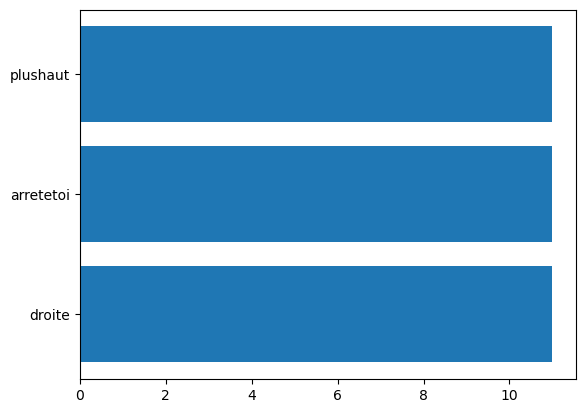

In [288]:
BaseT , LabelT = reduction_Label(Base_eval, Label_eval, keep_label, dict_Label_eval)
nbT = pd.DataFrame(LabelT).value_counts()
plt.barh(keep_label, nbT)
print(len(LabelT))

In [289]:
scale = StandardScaler()
BaseT_scale = scale.fit_transform(BaseT)

#### 2. Évaluation des meilleurs modèles sur la base de données d'évaluation :

données non normalisées :

In [290]:
print(f"Évaluation du meilleur modèle de regression logistique sur les nouvelles données : {best_Logist.score(BaseT, LabelT)}")

print(f"Évaluation du meilleur modèle de SVM sur les nouvelles données : {best_SVC.score(BaseT, LabelT)}")

print(f"Évaluation du meilleur modèle de AdaBoost sur les nouvelles données : {best_AdaBoost.score(BaseT, LabelT)}")

print(f"Évaluation du meilleur modèle de GradientBoosting sur les nouvelles données : {best_GradientBoosting.score(BaseT, LabelT)}")

print(f"Évaluation du meilleur modèle de MLPClassifier sur les nouvelles données : {best_MLPClassifier.score(BaseT, LabelT)}")


Évaluation du meilleur modèle de regression logistique sur les nouvelles données : 0.6666666666666666
Évaluation du meilleur modèle de SVM sur les nouvelles données : 0.6363636363636364
Évaluation du meilleur modèle de AdaBoost sur les nouvelles données : 0.48484848484848486
Évaluation du meilleur modèle de GradientBoosting sur les nouvelles données : 0.5454545454545454
Évaluation du meilleur modèle de MLPClassifier sur les nouvelles données : 0.7575757575757576


données normalisées :

In [291]:
print(f"Évaluation du meilleur modèle de regression logistique sur les nouvelles données scaled : {best_Logist_scale.score(BaseT_scale, LabelT)}")

print(f"Évaluation du meilleur modèle de SVM sur les nouvelles données scaled : {best_SVC_scale.score(BaseT_scale, LabelT)}")

print(f"Évaluation du meilleur modèle de AdaBoost sur les nouvelles données scaled: {best_AdaBoost.score(BaseT_scale, LabelT)}")

print(f"Évaluation du meilleur modèle de GradientBoosting sur les nouvelles données scaled : {best_GradientBoosting.score(BaseT_scale, LabelT)}")

print(f"Évaluation du meilleur modèle de MLPClassifier sur les nouvelles données scaled : {best_MLPClassifier.score(BaseT_scale, LabelT)}")

Évaluation du meilleur modèle de regression logistique sur les nouvelles données scaled : 0.7878787878787878
Évaluation du meilleur modèle de SVM sur les nouvelles données scaled : 0.6060606060606061
Évaluation du meilleur modèle de AdaBoost sur les nouvelles données scaled: 0.3333333333333333
Évaluation du meilleur modèle de GradientBoosting sur les nouvelles données scaled : 0.3333333333333333
Évaluation du meilleur modèle de MLPClassifier sur les nouvelles données scaled : 0.6363636363636364


- On obtient, comme attendu, de meilleurs scores d'évaluation avec le modèle des réseaux de neurone et la regression logistique
- Le score de la régression logistique est meilleur sur la base de données normalisée mais ce n'est pas le cas pour les autres modèles, la normalisation des données dans notre cas n'est pas pertinente.

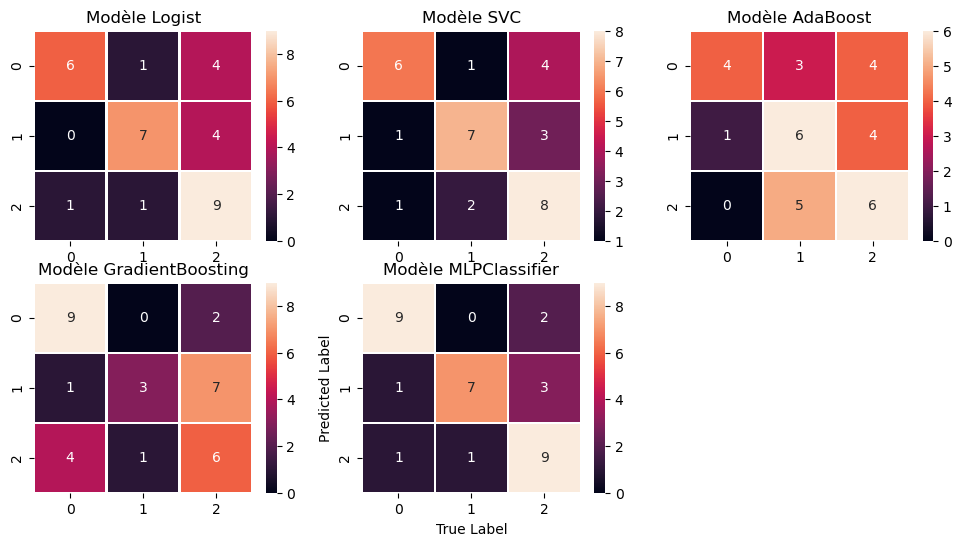

In [292]:
# nombre de modèles : Logist, SVC, AdaBoost, GradientBoost, MLPClassifier
pred = np.zeros((5, len(LabelT)))
pred[0,:] = best_Logist.predict(BaseT)
pred[1,:] = best_SVC.predict(BaseT)
pred[2,:] = best_AdaBoost.predict(BaseT)
pred[3,:] = best_GradientBoosting.predict(BaseT)
pred[4,:] = best_MLPClassifier.predict(BaseT)

modele_list = ["Logist", "SVC", "AdaBoost", "GradientBoosting", "MLPClassifier"]
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(2,3,i+1)
    sns.heatmap(metrics.confusion_matrix(LabelT, pred[i,:]), linewidth = 1 , annot = True)
    plt.title("Modèle " + modele_list[i])
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.savefig('Eval_confusion.png')
plt.show()

- On peut confirmer les observations précédentes en regardant les matrices de confusion des différents modèles.
- Les réseaux de neurone classifient le mieux nos données.
- le modèle de classification spectrale est supprimé puisqu'il n'est pas pertinent dans le cadre de notre étude.